# A Comparative Study of Categorical Variable Encoding Techniques for Binary Classification Algorithms

**By Elyas Shaswary, PhD**

# Introduction

Machine learning fits mathematical models to data to derive insights or make predictions. These models take features as input. A feature is a numeric representation of an aspect of raw data. Features sit between data and models in the machine learning pipeline. Feature engineering is the act of extracting features from raw data and transforming them into formats that are suitable for the machine learning model. It is a crucial step in the machine learning pipeline because the right features can ease the difficulty of modelling, and therefore enable the pipeline to output results of higher quality. 

Whether using a simple linear model or a deep neural network, one central problem, however, is how to represent discrete categorical features as input to the models. Since machine learning algorithms accept only numerical inputs, it is necessary to encode categorical features into numerical values using encoding techniques. 

A categorical variable, as the name suggests, is used to represent categories or labels. For example, the variable Gender with the values of male or female is categorical, and so is the variable marital status with the values of never married, married, divorced, or widowed. In some categorical variables, the labels have an intrinsic order, for example, in the variable Student's grade, the values of A, B, C, or Fail are ordered, A being the highest grade and Fail the lowest. These are called ordinal categorical variables. Variables in which the categories do not have an intrinsic order are called nominal categorical variables, such as the variable City, with the values of London, Manchester, Bristol, and so on.

The categories of a categorical variable are usually not numeric. For example, eye colour can be “black,” “blue,” “brown,” etc. Thus, an encoding method is needed to turn these non-numeric categories into numbers. It is tempting to simply assign an integer, say from 1 to k, to each of k possible categories—but the resulting values would be orderable against each other, which should not be permissible for categories.

Many machine learning algorithms are sensitive to the scale and magnitude of the features. In particular, the coefficients of the linear models depend on the scale of the feature, that is, changing the feature scale will change the coefficients' value. In linear models, as well as algorithms that depend on distance calculations, such as clustering and principal component analysis, features with bigger value ranges tend to dominate over features with smaller ranges. Thus, having features within a similar scale allows us to compare feature importance, and also helps algorithms converge faster, thus improving performance and training times.

In this work, the effect of several categorical encoding techniques on the performance of binary classification algorithms is investigated. The effect of feature scaling after categorical encoding will also be investigated.


# Preprocessing

In [1]:
# Load required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the dataset
# dataset = pd.read_csv('/content/drive/MyDrive/datasets/titanic.csv') # source: https://www.openml.org/d/40945
dataset = pd.read_csv('titanic.csv')
dataset.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [3]:
# drop least important features
dataset.drop(['name', 'ticket', 'home.dest', 'boat','body'], axis=1, inplace=True)

In [4]:
# check the number of rows and columns in the dataset
dataset.shape

(1309, 9)

In [5]:
# check the type of data stored in each column
dataset.dtypes

pclass        int64
survived      int64
sex          object
age         float64
sibsp         int64
parch         int64
fare        float64
cabin        object
embarked     object
dtype: object

In [6]:
# convert float64 to float32 for faster computations
for col in dataset.columns:
    if dataset[col].dtypes=='float64':
        dataset[col] = dataset[col].astype('float32')
    elif dataset[col].dtypes=='int64':
        dataset[col] = dataset[col].astype('int32')
    else:
        pass

In [7]:
dataset.dtypes

pclass        int32
survived      int32
sex          object
age         float32
sibsp         int32
parch         int32
fare        float32
cabin        object
embarked     object
dtype: object

In [8]:
# See the distribution of our target variable
dataset['survived'].value_counts()

0    809
1    500
Name: survived, dtype: int64

The data seems to be semi-imbalance 62% is negative case and 38% is positive case.

## Missing Data

In [9]:
# check for missing data
dataset.isnull().sum()

pclass         0
survived       0
sex            0
age          263
sibsp          0
parch          0
fare           1
cabin       1014
embarked       2
dtype: int64

In [10]:
# Drop observations with NA in embarked and fare since only a few are missing.
dataset.dropna(subset=['embarked','fare'], inplace=True)

In [11]:
# Shortening the cabin column
dataset['cabin'] = dataset['cabin'].astype(str).str[0]
dataset.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked
0,1,1,female,29.0000,0,0,211.337494,B,S
1,1,1,male,0.9167,1,2,151.550003,C,S
2,1,0,female,2.0000,1,2,151.550003,C,S
3,1,0,male,30.0000,1,2,151.550003,C,S
4,1,0,female,25.0000,1,2,151.550003,C,S


In [12]:
# Explore the number of unique values for each feature
for col in dataset.columns:
    print('{}: {} unique values'.format(col, dataset[col].nunique()))

pclass: 3 unique values
survived: 2 unique values
sex: 2 unique values
age: 97 unique values
sibsp: 7 unique values
parch: 8 unique values
fare: 280 unique values
cabin: 9 unique values
embarked: 3 unique values


In [13]:
# check cabin variable frequency
(dataset['cabin'].value_counts() / len(dataset)).sort_values()

T    0.000766
G    0.003828
F    0.016080
A    0.016845
E    0.031394
D    0.035222
B    0.048239
C    0.071975
n    0.775651
Name: cabin, dtype: float64

In [14]:
# drop observations with cabin = T and G since they are too few
dataset = dataset[dataset['cabin'] != 'T']
dataset = dataset[dataset['cabin'] != 'G']

In [15]:
# Divide into train and test set
X_train, X_test, y_train, y_test = train_test_split(
    dataset.drop(labels='survived', axis=1),  # predictors
    dataset['survived'],  # target
    test_size=0.25,
    random_state=0)

X_train.shape, X_test.shape

((975, 8), (325, 8))

In [16]:
# adding a missing indicator to age
X_train['age_missing'] = np.where(X_train['age'].isnull(),1,0)
X_test['age_missing'] = np.where(X_test['age'].isnull(),1,0)

**Missing indicator:** Missing indicator is typically used together with methods that assume data is missing at random (e.g., mean, median, mode, or random sample imputations). It covers 2 angles:
* if the data are missing completely at random, this would be captured by the mean, median or mode imputation, 
* if the data were not missing completely at random, this would be captured by the additional "missing indicator" variable.

In [17]:
# replace null values in numerical variables by the mean
def impute_na(df, variable, value):
    df[variable].fillna(value, inplace=True)

impute_na(X_test, 'age', X_train['age'].mean())
impute_na(X_train, 'age',  X_train['age'].mean())

**Mean Imputation:** consists of replacing all occurrence of missing values within a variable by the mean. 

**Assumptions:**
* It assumes that the data are missing at random,
* Missing observation most likely looks like the majority of the observations in the variable (aka, the mean/median). 

**Pros:**
* Easy to implement, 
* Fast way of obtaining complete datasets, 
* Can be integrated into production (during model deployment). 

**Cons:**
* Distortion of the original variable distribution, 
* Distortion of the original variance, 
* Distortion of the covariance with the remaining variables of the dataset, where the distortion would be higher for higher the percentage of missing data.

In [18]:
X_train.head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,age_missing
1277,3,male,22.000000,0,0,7.225,n,C,0
1284,3,male,30.082476,0,0,8.050,n,S,1
811,3,female,48.000000,1,3,34.375,n,S,0
411,2,female,38.000000,0,0,13.000,n,S,0
1306,3,male,26.500000,0,0,7.225,n,C,0


In [19]:
# check that we have no missing data after NA imputation
X_train.isnull().sum(), X_test.isnull().sum()

(pclass         0
 sex            0
 age            0
 sibsp          0
 parch          0
 fare           0
 cabin          0
 embarked       0
 age_missing    0
 dtype: int64,
 pclass         0
 sex            0
 age            0
 sibsp          0
 parch          0
 fare           0
 cabin          0
 embarked       0
 age_missing    0
 dtype: int64)

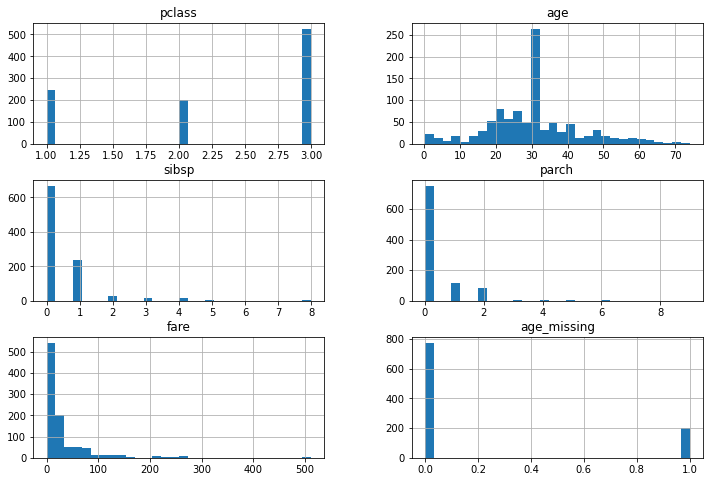

In [20]:
X_train.hist(bins=30, figsize=(12,8))
plt.show()

**Note:** we are treating the missing values in the cabin as an additional category. 

Since it makes no assumption on the data, it's easy to implement, can be integrated into production, and captures the importance of "missingness" if there is one. 

However, if the number of missing data is small, it creates an additional category which may lead to an additional rare label (increasing cardinality).



---



## One-Hot Encoding

In one-hot encoding, a categorical variable is represented as a group of binary variables, where each binary variable represents one category. The binary variable indicates whether the category is present in observation (1) or not (0).

The advantages of this technique are that it makes no assumption about the distribution or categories of the categorical variable, it keeps all the information of the categorical variable, and is suitable for linear models. 

However, the limitations of this technique are the expansion of the feature space, does not add extra information while encoding, and many dummy variables may be identical, which would introduce redundant information.

In [21]:
def get_OHE(df):

    df_OHE = pd.concat(
        [df[['pclass', 'age', 'sibsp', 'parch', 'fare']],
         pd.get_dummies(df[['sex', 'cabin', 'embarked']], drop_first=False)],
        axis=1)

    return df_OHE

X_train_OHE = get_OHE(X_train)
X_test_OHE = get_OHE(X_test)

X_train_OHE.head()

,pclass,age,sibsp,parch,fare,sex_female,sex_male,cabin_A,cabin_B,cabin_C,cabin_D,cabin_E,cabin_F,cabin_n,embarked_C,embarked_Q,embarked_S
1277,3,22.000000,0,0,7.225,0,1,0,0,0,0,0,0,1,1,0,0
1284,3,30.082476,0,0,8.050,0,1,0,0,0,0,0,0,1,0,0,1
811,3,48.000000,1,3,34.375,1,0,0,0,0,0,0,0,1,0,0,1
411,2,38.000000,0,0,13.000,1,0,0,0,0,0,0,0,1,0,0,1
1306,3,26.500000,0,0,7.225,0,1,0,0,0,0,0,0,1,1,0,0


In [22]:
X_test_OHE.head()

,pclass,age,sibsp,parch,fare,sex_female,sex_male,cabin_A,cabin_B,cabin_C,cabin_D,cabin_E,cabin_F,cabin_n,embarked_C,embarked_Q,embarked_S
582,2,12.0,0,0,15.750000,1,0,0,0,0,0,0,0,1,0,0,1
1017,3,21.0,0,0,7.775000,0,1,0,0,0,0,0,0,1,0,0,1
762,3,1.0,1,2,20.575001,0,1,0,0,0,0,0,0,1,0,0,1
449,2,54.0,1,3,23.000000,1,0,0,0,0,0,0,0,1,0,0,1
188,1,51.0,0,1,39.400002,1,0,0,0,0,1,0,0,0,0,0,1


## One-Hot Encoding with k - 1 Dummy Variables

Often a categorical variable can be encoded by creating k-1 binary variables, where k is the number of the discrete categories. One hot encoding into k-1 binary variable takes into account that we can use 1 less dimension and still represent the whole information. 

Usually, it is preferred over one hot encoding with k dummy variable as it avoids introducing redundant information. 

However, there are a few occasions when it is better to encode variables into k dummy variables, such as when building tree-based algorithms, when doing feature selection by recursive algorithms, and when interested in determining the importance of every single category.


In [23]:
def get_OHE_kminus(df):

    df_OHE_km = pd.concat(
        [df[['pclass', 'age', 'sibsp', 'parch', 'fare']],
         pd.get_dummies(df[['sex', 'cabin', 'embarked']], drop_first=True)],
        axis=1)

    return df_OHE_km

X_train_OHE_kminus = get_OHE_kminus(X_train)
X_test_OHE_kminus = get_OHE_kminus(X_test)

X_train_OHE_kminus.head()

,pclass,age,sibsp,parch,fare,sex_male,cabin_B,cabin_C,cabin_D,cabin_E,cabin_F,cabin_n,embarked_Q,embarked_S
1277,3,22.000000,0,0,7.225,1,0,0,0,0,0,1,0,0
1284,3,30.082476,0,0,8.050,1,0,0,0,0,0,1,0,1
811,3,48.000000,1,3,34.375,0,0,0,0,0,0,1,0,1
411,2,38.000000,0,0,13.000,0,0,0,0,0,0,1,0,1
1306,3,26.500000,0,0,7.225,1,0,0,0,0,0,1,0,0


In [24]:
X_test_OHE_kminus.head()

,pclass,age,sibsp,parch,fare,sex_male,cabin_B,cabin_C,cabin_D,cabin_E,cabin_F,cabin_n,embarked_Q,embarked_S
582,2,12.0,0,0,15.750000,0,0,0,0,0,0,1,0,1
1017,3,21.0,0,0,7.775000,1,0,0,0,0,0,1,0,1
762,3,1.0,1,2,20.575001,1,0,0,0,0,0,1,0,1
449,2,54.0,1,3,23.000000,0,0,0,0,0,0,1,0,1
188,1,51.0,0,1,39.400002,0,0,0,1,0,0,0,0,1


## Count or Frequency Encoding

Count encoding replaces the categories with the count or percentage of the observations that show that category in the dataset. It captures the representation of each label in the dataset. It assumes that the number of observations shown by each category is predictive of the target. 

The advantages of this technique are that it is straightforward to implement, does not expand the feature space, and can work well with tree-based algorithms.

However, the limitation of this technique is that it is not suitable for linear models, it does not handle new categories in the test set automatically, and if two different categories appear the same amount of time in the dataset, that is, they appear in the same number of observations, they will be replaced by the same number (may lose valuable information).


In [25]:
def categorical_to_counts(df_train, df_test):

    # make a temporary copy of the original dataframes
    df_train_temp = df_train.copy()
    df_test_temp = df_test.copy()

    for col in ['sex', 'cabin', 'embarked']:

        # make dictionary mapping category to counts
        counts_map = df_train_temp[col].value_counts().to_dict()

        # remap the labels to their counts
        df_train_temp[col] = df_train_temp[col].map(counts_map)
        df_test_temp[col] = df_test_temp[col].map(counts_map)

    return df_train_temp, df_test_temp

X_train_count, X_test_count = categorical_to_counts(X_train, X_test)

X_train_count.head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,age_missing
1277,3,628,22.000000,0,0,7.225,749,199,0
1284,3,628,30.082476,0,0,8.050,749,680,1
811,3,347,48.000000,1,3,34.375,749,680,0
411,2,347,38.000000,0,0,13.000,749,680,0
1306,3,628,26.500000,0,0,7.225,749,199,0


In [26]:
X_test_count.head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,age_missing
582,2,347,12.0,0,0,15.750000,749,680,0
1017,3,628,21.0,0,0,7.775000,749,680,0
762,3,628,1.0,1,2,20.575001,749,680,0
449,2,347,54.0,1,3,23.000000,749,680,0
188,1,347,51.0,0,1,39.400002,36,680,0


## Ordered Integar Encoding

Ordered integer (ordinal) encoding replaces the categories by integers from 1 to k, where k is the number of distinct categories in the variable but this numbering is informed by the mean of the target for each category. This technique can be implemented as follows:
1. Calculate the mean value of the target per category.
2. Order the categories from the one with the lowest to the one with the highest target mean value.
3. Assign digits to the ordered categories, starting with 0 to the first category all of the ways up to k-1 to the last category, where k is the number of distinct categories.

The advantages of this technique are that it is straightforward to implement, does not expand the feature space, and creates a monotonic relationship between categories and targets.

However, the limitations of this technique are that it may lead to over-fitting, and is difficult to implement together with cross-validation with current libraries.


In [27]:
def categories_to_ordered(df_train, df_test, y_train, y_test):

    # make a temporary copy of the datasets
    df_train_temp = pd.concat([df_train, y_train], axis=1).copy()
    df_test_temp = pd.concat([df_test, y_test], axis=1).copy()

    for col in ['sex', 'cabin', 'embarked']:

        # order categories according to target mean
        ordered_labels = df_train_temp.groupby(
            [col])['survived'].mean().sort_values().index

        # create the dictionary to map the ordered labels to an ordinal number
        ordinal_label = {k: i for i, k in enumerate(ordered_labels, 0)}

        # remap the categories  to these ordinal numbers
        df_train_temp[col] = df_train[col].map(ordinal_label)
        df_test_temp[col] = df_test[col].map(ordinal_label)

    # remove the target
    df_train_temp.drop(['survived'], axis=1, inplace=True)
    df_test_temp.drop(['survived'], axis=1, inplace=True)

    return df_train_temp, df_test_temp


X_train_ordered, X_test_ordered = categories_to_ordered(
    X_train, X_test, y_train, y_test)

X_train_ordered.head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,age_missing
1277,3,0,22.000000,0,0,7.225,0,2,0
1284,3,0,30.082476,0,0,8.050,0,0,1
811,3,1,48.000000,1,3,34.375,0,0,0
411,2,1,38.000000,0,0,13.000,0,0,0
1306,3,0,26.500000,0,0,7.225,0,2,0


In [28]:
X_test_ordered.head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,age_missing
582,2,1,12.0,0,0,15.750000,0,0,0
1017,3,0,21.0,0,0,7.775000,0,0,0
762,3,0,1.0,1,2,20.575001,0,0,0
449,2,1,54.0,1,3,23.000000,0,0,0
188,1,1,51.0,0,1,39.400002,6,0,0


## Mean Encoding

Mean encoding or target encoding implies replacing the categories with the average target value for that category. For example, if we have a City variable, with the categories of London, Manchester, and Bristol, and we want to predict the default rate; if the default rate for London is 30%, we replace London with 0.3; if the default rate for Manchester is 20%, we replace Manchester with 0.2; and so on. The same can be done with a continuous target.

The advantages of this technique are that it is straightforward to implement, it does not expand the feature space, and it creates a monotonic relationship between categories and targets.

However, the limitations of this technique are that it may lead to over-fitting, it is difficult to implement together with cross-validation with current libraries, and if two categories show the same mean of the target, they will be replaced by the same number (may lead to potential loss of value).


In [29]:
def categories_to_mean(df_train, df_test, y_train, y_test):

    # make a temporary copy of the datasets
    df_train_temp = pd.concat([df_train, y_train], axis=1).copy()
    df_test_temp = pd.concat([df_test, y_test], axis=1).copy()

    for col in ['sex', 'cabin', 'embarked']:

        # calculate mean target per category
        ordered_labels = df_train_temp.groupby(
            [col])['survived'].mean().to_dict()

        # remap the categories to target mean
        df_train_temp[col] = df_train[col].map(ordered_labels)
        df_test_temp[col] = df_test[col].map(ordered_labels)

    # remove the target
    df_train_temp.drop(['survived'], axis=1, inplace=True)
    df_test_temp.drop(['survived'], axis=1, inplace=True)

    return df_train_temp, df_test_temp


X_train_mean, X_test_mean = categories_to_mean(
    X_train, X_test, y_train, y_test)

X_train_mean.head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,age_missing
1277,3,0.176752,22.000000,0,0,7.225,0.287049,0.537688,0
1284,3,0.176752,30.082476,0,0,8.050,0.287049,0.326471,1
811,3,0.720461,48.000000,1,3,34.375,0.287049,0.326471,0
411,2,0.720461,38.000000,0,0,13.000,0.287049,0.326471,0
1306,3,0.176752,26.500000,0,0,7.225,0.287049,0.537688,0


In [30]:
X_test_mean.head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,age_missing
582,2,0.720461,12.0,0,0,15.750000,0.287049,0.326471,0
1017,3,0.176752,21.0,0,0,7.775000,0.287049,0.326471,0
762,3,0.176752,1.0,1,2,20.575001,0.287049,0.326471,0
449,2,0.720461,54.0,1,3,23.000000,0.287049,0.326471,0
188,1,0.720461,51.0,0,1,39.400002,0.722222,0.326471,0


## Probability Ratio

Probability ratio (or Weight of Evidence, WoE) is another categorical encoding technique where each category is replaced by the natural log of the ratio of the proportion of good events and bad events.  

An example is shown below:
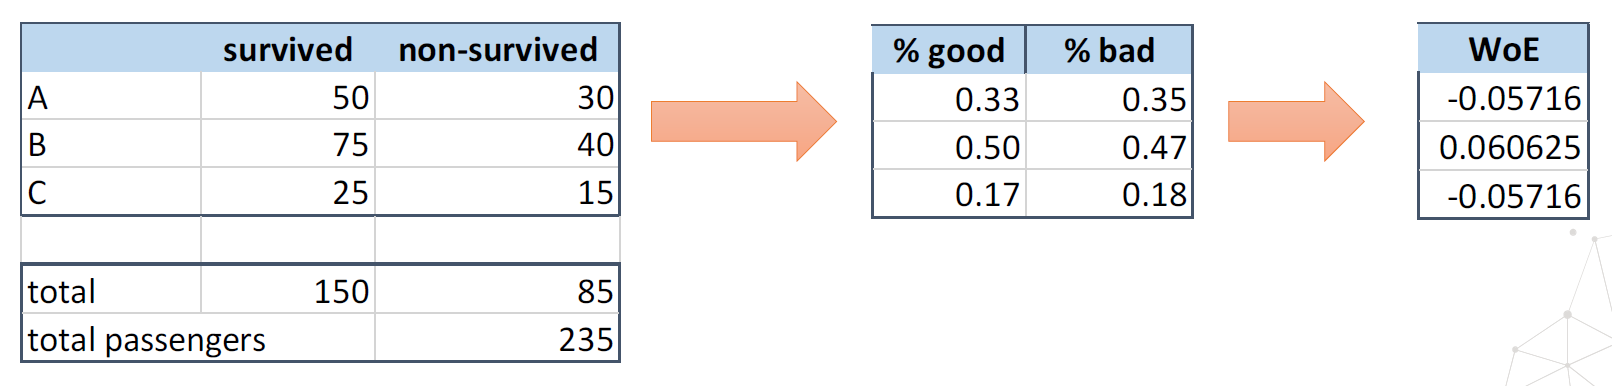

Probability ratio was developed primarily for credit and financial industries to facilitate variable screening and exploratory analysis and to build more predictive linear models to evaluate the risk of loan default; that is, to predict how likely money lent to a person or institution is to be lost.

The advantages of the technique it that it creates a monotonic relationship between the target and the variables, it orders the categories on a "logistic" scale which is natural for logistic regression, and the transformed variables can then be compared because they are on the same scale (therefore, it is possible to determine which one is more predictive).

The limitation of this technique is that it may lead to over-fitting and it is not defined when the denominator or numerator is 0.


In [31]:
def categories_to_ratio(df_train, df_test, y_train, y_test):

    # make a temporary copy of the datasets
    df_train_temp = pd.concat([df_train, y_train], axis=1).copy()
    df_test_temp = pd.concat([df_test, y_test], axis=1).copy()

    for col in ['sex', 'cabin', 'embarked']:

        # create df containing the different parts of the WoE equation
        # prob survived =1
        prob_df = pd.DataFrame(df_train_temp.groupby([col])['survived'].mean())

        # prob survived = 0
        prob_df['died'] = 1-prob_df.survived

        # calculate WoE
        prob_df['Ratio'] = np.log(prob_df.survived/prob_df.died)

        # capture woe in dictionary
        woe = prob_df['Ratio'].to_dict()

        # re-map the labels to WoE
        df_train_temp[col] = df_train[col].map(woe)
        df_test_temp[col] = df_test[col].map(woe)

    # drop the target
    df_train_temp.drop(['survived'], axis=1, inplace=True)
    df_test_temp.drop(['survived'], axis=1, inplace=True)

    return df_train_temp, df_test_temp


X_train_ratio, X_test_ratio = categories_to_ratio(X_train, X_test, y_train, y_test)

X_train_ratio.head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,age_missing
1277,3,-1.538513,22.000000,0,0,7.225,-0.909758,0.151040,0
1284,3,-1.538513,30.082476,0,0,8.050,-0.909758,-0.724192,1
811,3,0.946750,48.000000,1,3,34.375,-0.909758,-0.724192,0
411,2,0.946750,38.000000,0,0,13.000,-0.909758,-0.724192,0
1306,3,-1.538513,26.500000,0,0,7.225,-0.909758,0.151040,0


In [32]:
X_test_ratio.head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,age_missing
582,2,0.946750,12.0,0,0,15.750000,-0.909758,-0.724192,0
1017,3,-1.538513,21.0,0,0,7.775000,-0.909758,-0.724192,0
762,3,-1.538513,1.0,1,2,20.575001,-0.909758,-0.724192,0
449,2,0.946750,54.0,1,3,23.000000,-0.909758,-0.724192,0
188,1,0.946750,51.0,0,1,39.400002,0.955511,-0.724192,0


## Feature Scaling

In [33]:
def apply_scaler(df_train, df_test):
    
    # Fit the scaler on the training data
    scaler = StandardScaler()
    scaler.fit(df_train)

    # Scale the training and test sets
    features = df_train.columns

    df_train[features] = scaler.transform(df_train[features])
    df_test[features] = scaler.transform(df_test[features])

    return df_train, df_test

In [34]:
# Create separte sets of data for feature scaling
X_train_OHE_sc, X_test_OHE_sc = apply_scaler(X_train_OHE.copy(), X_test_OHE.copy())
X_train_OHE_kminus_sc, X_test_OHE_kminus_sc = apply_scaler(X_train_OHE_kminus.copy(), X_test_OHE_kminus.copy())
X_train_count_sc, X_test_count_sc = apply_scaler(X_train_count.copy(), X_test_count.copy())
X_train_ordered_sc, X_test_ordered_sc = apply_scaler(X_train_ordered.copy(), X_test_ordered.copy())
X_train_mean_sc, X_test_mean_sc = apply_scaler(X_train_mean.copy(), X_test_mean.copy())
X_train_ratio_sc, X_test_ratio_sc = apply_scaler(X_train_ratio.copy(), X_test_ratio.copy())

In [35]:
X_train_OHE.head()

,pclass,age,sibsp,parch,fare,sex_female,sex_male,cabin_A,cabin_B,cabin_C,cabin_D,cabin_E,cabin_F,cabin_n,embarked_C,embarked_Q,embarked_S
1277,3,22.000000,0,0,7.225,0,1,0,0,0,0,0,0,1,1,0,0
1284,3,30.082476,0,0,8.050,0,1,0,0,0,0,0,0,1,0,0,1
811,3,48.000000,1,3,34.375,1,0,0,0,0,0,0,0,1,0,0,1
411,2,38.000000,0,0,13.000,1,0,0,0,0,0,0,0,1,0,0,1
1306,3,26.500000,0,0,7.225,0,1,0,0,0,0,0,0,1,1,0,0


In [36]:
X_train_OHE_sc.head()

,pclass,age,sibsp,parch,fare,sex_female,sex_male,cabin_A,cabin_B,cabin_C,cabin_D,cabin_E,cabin_F,cabin_n,embarked_C,embarked_Q,embarked_S
1277,0.846621,-6.439402e-01,-0.473740,-0.441095,-0.521408,-0.743336,0.743336,-0.140977,-0.227552,-0.286585,-0.195803,-0.184213,-0.133211,0.549305,1.974715,-0.330477,-1.518251
1284,0.846621,1.665529e-07,-0.473740,-0.441095,-0.505065,-0.743336,0.743336,-0.140977,-0.227552,-0.286585,-0.195803,-0.184213,-0.133211,0.549305,-0.506402,-0.330477,0.658653
811,0.846621,1.427511e+00,0.484551,2.981196,0.016423,1.345287,-1.345287,-0.140977,-0.227552,-0.286585,-0.195803,-0.184213,-0.133211,0.549305,-0.506402,-0.330477,0.658653
411,-0.339378,6.307987e-01,-0.473740,-0.441095,-0.407008,1.345287,-1.345287,-0.140977,-0.227552,-0.286585,-0.195803,-0.184213,-0.133211,0.549305,-0.506402,-0.330477,0.658653
1306,0.846621,-2.854199e-01,-0.473740,-0.441095,-0.521408,-0.743336,0.743336,-0.140977,-0.227552,-0.286585,-0.195803,-0.184213,-0.133211,0.549305,1.974715,-0.330477,-1.518251


Dataframes to store scoring of each techniue.

In [37]:
model_logit = {'Encoding':[], 'ROC_AUC': [], 'Accuracy': []}
model_logit = pd.DataFrame(model_logit)

In [38]:
model_rfc = {'Encoding':[], 'ROC_AUC': [], 'Accuracy': []}
model_rfc = pd.DataFrame(model_rfc)

In [39]:
model_ann = {'Encoding':[], 'ROC_AUC': [], 'Accuracy': []}
model_ann = pd.DataFrame(model_ann)

In [40]:
model_nb = {'Encoding':[], 'ROC_AUC': [], 'Accuracy': []}
model_nb = pd.DataFrame(model_nb)

In [41]:
model_logit_sc = {'Encoding':[], 'ROC_AUC': [], 'Accuracy': []}
model_logit_sc = pd.DataFrame(model_logit_sc)

In [42]:
model_rfc_sc = {'Encoding':[], 'ROC_AUC': [], 'Accuracy': []}
model_rfc_sc = pd.DataFrame(model_rfc_sc)

In [43]:
model_ann_sc = {'Encoding':[], 'ROC_AUC': [], 'Accuracy': []}
model_ann_sc = pd.DataFrame(model_ann_sc)

In [44]:
model_nb_sc = {'Encoding':[], 'ROC_AUC': [], 'Accuracy': []}
model_nb_sc = pd.DataFrame(model_nb_sc)

In [45]:
def append_scores(dict_name, label_name, test_score):
    dict_name = dict_name.append({'Encoding': label_name, 'ROC_AUC': test_score[0]*100, 'Accuracy': test_score[1]*100}, ignore_index=True)
    return dict_name

The performance of each encoding technique will be evaluated using 4 different classification algorithms. 

# Logistic Regression

Logistic regression is a simple, linear classifier. Due to its simplicity, it’s often a good first classifier to try. It takes a weighted combination of the input features and passes it through a sigmoid function, which smoothly maps any real number to a number between 0 and 1. The function transforms a real number input, x, into a number between 0 and 1. It has one set of parameters, w, which represents the slope of the increase around the midpoint, 0.5. The intercept term b denotes the input value where the function output crosses the midpoint. A logistic classifier would predict the positive class if the sigmoid output is greater than 0.5, and the negative class otherwise. By varying w and b, one can control where that change in decision occurs, and how fast the decision should respond to changing input values around that point.

In [46]:
def run_cv_logistic_regression(df_train, df_test, y_train, y_test):
    # Logistic Regression
    logit = LogisticRegression(solver='liblinear', random_state=4, max_iter=10000)

    # hyperparameter space
    param_grid = dict(penalty=['l1', 'l2'], C=[0.01, 0.1, 1, 10, 100], )

    # K-Fold Cross-Validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=4)

    # search
    clf =  GridSearchCV(
    logit,
    param_grid,
    scoring='roc_auc',
    cv=skf, # stratified k-fold
    refit=True, # refits best model to entire dataset
    n_jobs = -1,
    )

    clf.fit(df_train, y_train)

    # best hyperparameters
    print('Best model parameters: \t{}\n'.format(clf.best_params_))

    # get the predictions
    train_preds = clf.predict(df_train)
    test_preds = clf.predict(df_test)

    # calculate scores
    train_roc_auc = roc_auc_score(y_train, train_preds)
    train_accuarcy = accuracy_score(y_train, train_preds)

    test_roc_auc = roc_auc_score(y_test, test_preds)    
    test_accuarcy = accuracy_score(y_test, test_preds)

    print('Trainig Set\t-\tROC-AUC:\t{:.2f} %'.format(train_roc_auc*100))
    print('Trainig Set\t-\tAccuracy:\t{:.2f} %'.format(train_accuarcy*100))
    print('Testing Set\t-\tROC-AUC:\t{:.2f} %'.format(test_roc_auc*100))
    print('Testing Set\t-\tAccuracy:\t{:.2f} %'.format(test_accuarcy*100))

    return [test_roc_auc, test_accuarcy]

In [47]:
test_score = run_cv_logistic_regression(X_train_OHE, X_test_OHE, y_train, y_test)
model_logit = append_scores(model_logit,'One Hot Encoding', test_score)

Best model parameters: 	{'C': 1, 'penalty': 'l2'}

Trainig Set	-	ROC-AUC:	78.58 %
Trainig Set	-	Accuracy:	80.72 %
Testing Set	-	ROC-AUC:	75.51 %
Testing Set	-	Accuracy:	77.23 %


In [48]:
test_score = run_cv_logistic_regression(X_train_OHE_kminus, X_test_OHE_kminus, y_train, y_test)
model_logit = append_scores(model_logit, 'One Hot Encoding (k-1)', test_score)

Best model parameters: 	{'C': 1, 'penalty': 'l1'}

Trainig Set	-	ROC-AUC:	78.67 %
Trainig Set	-	Accuracy:	80.82 %
Testing Set	-	ROC-AUC:	74.76 %
Testing Set	-	Accuracy:	76.62 %


In [49]:
test_score = run_cv_logistic_regression(X_train_count, X_test_count, y_train, y_test)
model_logit = append_scores(model_logit, 'Count Encoding', test_score)

Best model parameters: 	{'C': 100, 'penalty': 'l2'}

Trainig Set	-	ROC-AUC:	77.79 %
Trainig Set	-	Accuracy:	80.00 %
Testing Set	-	ROC-AUC:	75.51 %
Testing Set	-	Accuracy:	77.23 %


In [50]:
test_score = run_cv_logistic_regression(X_train_ordered, X_test_ordered, y_train, y_test)
model_logit = append_scores(model_logit, 'Ordered Integer Encoding', test_score)

Best model parameters: 	{'C': 100, 'penalty': 'l1'}

Trainig Set	-	ROC-AUC:	78.48 %
Trainig Set	-	Accuracy:	80.51 %
Testing Set	-	ROC-AUC:	75.51 %
Testing Set	-	Accuracy:	77.23 %


In [51]:
test_score = run_cv_logistic_regression(X_train_mean, X_test_mean, y_train, y_test)
model_logit = append_scores(model_logit, 'Mean Encoding', test_score)

Best model parameters: 	{'C': 1, 'penalty': 'l1'}

Trainig Set	-	ROC-AUC:	77.95 %
Trainig Set	-	Accuracy:	80.21 %
Testing Set	-	ROC-AUC:	73.97 %
Testing Set	-	Accuracy:	75.69 %


In [52]:
test_score = run_cv_logistic_regression(X_train_ratio, X_test_ratio, y_train, y_test)
model_logit = append_scores(model_logit, 'Probabilty Ratio Encoding', test_score)

Best model parameters: 	{'C': 10, 'penalty': 'l2'}

Trainig Set	-	ROC-AUC:	77.87 %
Trainig Set	-	Accuracy:	80.10 %
Testing Set	-	ROC-AUC:	74.87 %
Testing Set	-	Accuracy:	76.62 %


In [53]:
test_score = run_cv_logistic_regression(X_train_OHE_sc, X_test_OHE_sc, y_train, y_test)
model_logit_sc = append_scores(model_logit_sc,'One Hot Encoding', test_score)

Best model parameters: 	{'C': 1, 'penalty': 'l2'}

Trainig Set	-	ROC-AUC:	78.98 %
Trainig Set	-	Accuracy:	80.92 %
Testing Set	-	ROC-AUC:	75.51 %
Testing Set	-	Accuracy:	77.23 %


In [54]:
test_score = run_cv_logistic_regression(X_train_OHE_kminus_sc, X_test_OHE_kminus_sc, y_train, y_test)
model_logit_sc = append_scores(model_logit_sc, 'One Hot Encoding (k-1)', test_score)

Best model parameters: 	{'C': 1, 'penalty': 'l1'}

Trainig Set	-	ROC-AUC:	78.92 %
Trainig Set	-	Accuracy:	80.92 %
Testing Set	-	ROC-AUC:	75.51 %
Testing Set	-	Accuracy:	77.23 %


In [55]:
test_score = run_cv_logistic_regression(X_train_count_sc, X_test_count_sc, y_train, y_test)
model_logit_sc = append_scores(model_logit_sc, 'Count Encoding', test_score)

Best model parameters: 	{'C': 10, 'penalty': 'l2'}

Trainig Set	-	ROC-AUC:	77.84 %
Trainig Set	-	Accuracy:	80.00 %
Testing Set	-	ROC-AUC:	75.88 %
Testing Set	-	Accuracy:	77.54 %


In [56]:
test_score = run_cv_logistic_regression(X_train_ordered_sc, X_test_ordered_sc, y_train, y_test)
model_logit_sc = append_scores(model_logit_sc, 'Ordered Integer Encoding', test_score)

Best model parameters: 	{'C': 100, 'penalty': 'l1'}

Trainig Set	-	ROC-AUC:	78.48 %
Trainig Set	-	Accuracy:	80.51 %
Testing Set	-	ROC-AUC:	75.51 %
Testing Set	-	Accuracy:	77.23 %


In [57]:
test_score = run_cv_logistic_regression(X_train_mean_sc, X_test_mean_sc, y_train, y_test)
model_logit_sc = append_scores(model_logit_sc, 'Mean Encoding', test_score)

Best model parameters: 	{'C': 1, 'penalty': 'l2'}

Trainig Set	-	ROC-AUC:	77.87 %
Trainig Set	-	Accuracy:	80.10 %
Testing Set	-	ROC-AUC:	74.61 %
Testing Set	-	Accuracy:	76.31 %


In [58]:
test_score = run_cv_logistic_regression(X_train_ratio_sc, X_test_ratio_sc, y_train, y_test)
model_logit_sc = append_scores(model_logit_sc, 'Probabilty Ratio Encoding', test_score)

Best model parameters: 	{'C': 0.1, 'penalty': 'l2'}

Trainig Set	-	ROC-AUC:	78.04 %
Trainig Set	-	Accuracy:	80.10 %
Testing Set	-	ROC-AUC:	74.87 %
Testing Set	-	Accuracy:	76.62 %


## Results

In [59]:
model_logit

,Encoding,ROC_AUC,Accuracy
0,One Hot Encoding,75.505978,77.230769
1,One Hot Encoding (k-1),74.759709,76.615385
2,Count Encoding,75.505978,77.230769
3,Ordered Integer Encoding,75.505978,77.230769
4,Mean Encoding,73.974369,75.692308
5,Probabilty Ratio Encoding,74.871064,76.615385


In [60]:
model_logit_sc

,Encoding,ROC_AUC,Accuracy
0,One Hot Encoding,75.505978,77.230769
1,One Hot Encoding (k-1),75.505978,77.230769
2,Count Encoding,75.879112,77.538462
3,Ordered Integer Encoding,75.505978,77.230769
4,Mean Encoding,74.609283,76.307692
5,Probabilty Ratio Encoding,74.871064,76.615385


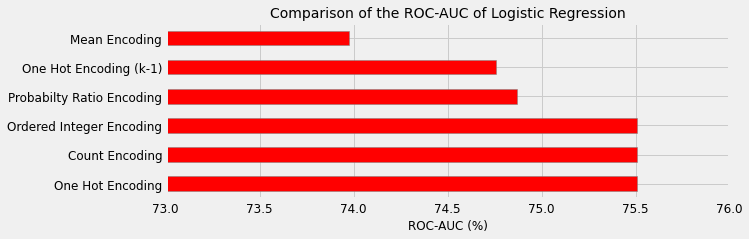

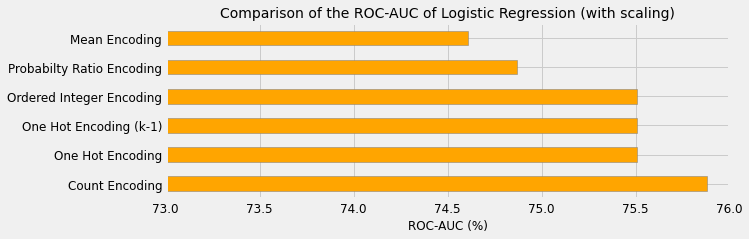

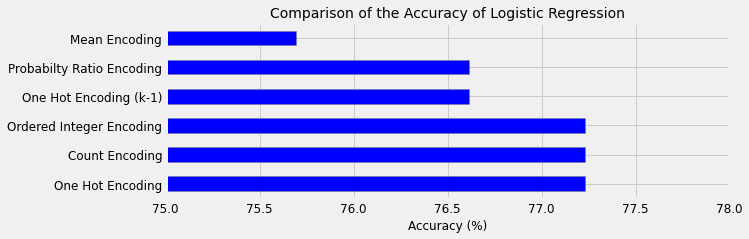

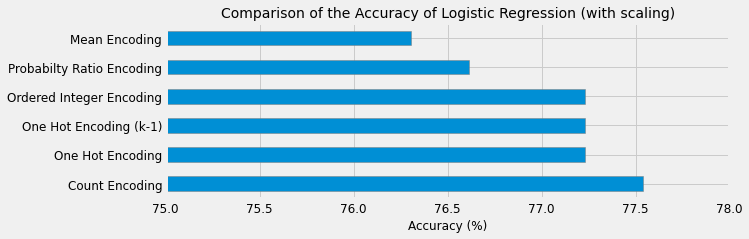

In [128]:
plt.style.use('fivethirtyeight');
model_logit.sort_values('ROC_AUC', ascending = False).plot(x = 'Encoding', y = 'ROC_AUC', kind = 'barh', color = 'red', edgecolor = 'gray', figsize=(9,3));
plt.ylabel(''); plt.yticks(size = 12); plt.xlabel('ROC-AUC (%)',size = 12); plt.xticks(size = 12);
plt.title('Comparison of the ROC-AUC of Logistic Regression', size = 14); plt.xlim([73, 76]); plt.legend().set_visible(False);

plt.style.use('fivethirtyeight');
model_logit_sc.sort_values('ROC_AUC', ascending = False).plot(x = 'Encoding', y = 'ROC_AUC', kind = 'barh', color = 'orange', edgecolor = 'gray', figsize=(9,3));
plt.ylabel(''); plt.yticks(size = 12); plt.xlabel('ROC-AUC (%)',size = 12); plt.xticks(size = 12);
plt.title('Comparison of the ROC-AUC of Logistic Regression (with scaling)', size = 14); plt.xlim([73, 76]); plt.legend().set_visible(False);

model_logit.sort_values('Accuracy', ascending = False).plot(x = 'Encoding', y = 'Accuracy', kind = 'barh', color = 'blue', edgecolor = 'gray', figsize=(9,3));
plt.ylabel(''); plt.yticks(size = 12); plt.xlabel('Accuracy (%)',size = 12); plt.xticks(size = 12);
plt.title('Comparison of the Accuracy of Logistic Regression', size = 14); plt.xlim([75, 78]); plt.legend().set_visible(False);

model_logit_sc.sort_values('Accuracy', ascending = False).plot(x = 'Encoding', y = 'Accuracy', kind = 'barh', edgecolor = 'gray', figsize=(9,3));
plt.ylabel(''); plt.yticks(size = 12); plt.xlabel('Accuracy (%)',size = 12); plt.xticks(size = 12);
plt.title('Comparison of the Accuracy of Logistic Regression (with scaling)', size = 14); plt.xlim([75, 78]); plt.legend().set_visible(False);

Count encoding the highest ROC-AUC and accuracy scores for linear regression method, however, its score was not significantly higher than other encoding techniques. Generally, all encoding techniques had similar scores. 
Feature scaling did not affect the score of the encoding techniques, except for the mean encoding, count encoding and one hot encoding (k-1 dummy) encoding where the scores were marginally higher with feature scaling. It was expected that with feature scaling the performance of the logistic regression would be higher since gradient descent-based algorithm is sensitive to feature scaling. However, it was not observed in all encoding techniques.


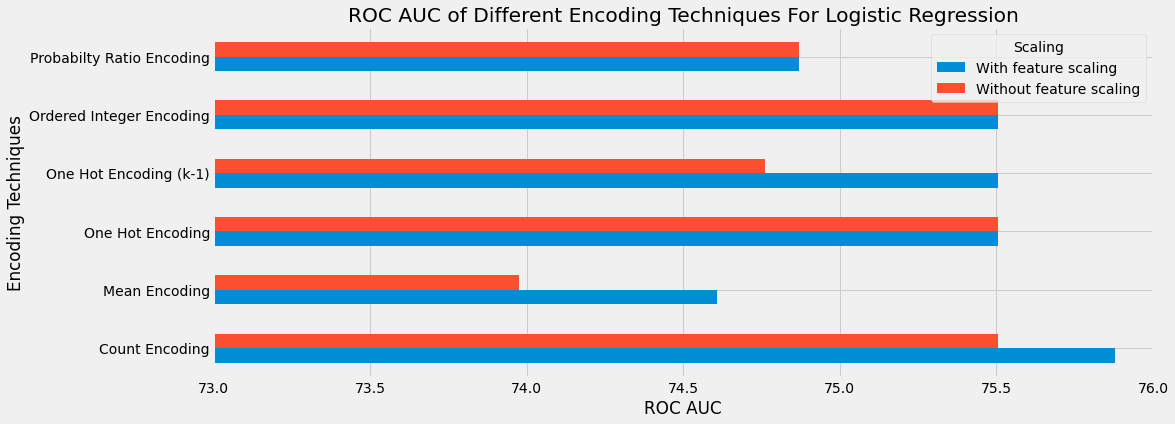

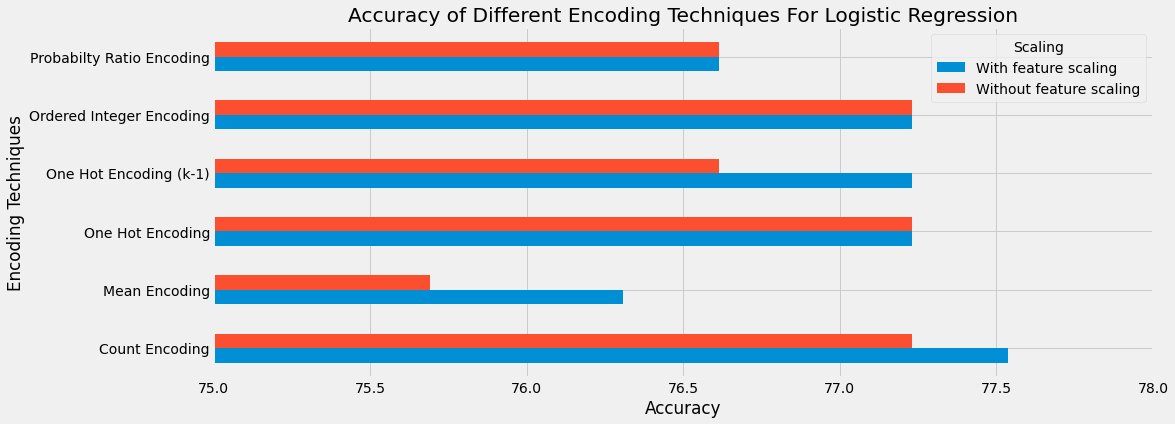

In [129]:
a1 = model_logit.copy()
a1['Scaling']='Without feature scaling'
a1 = a1.drop('Accuracy',1)

a2 = model_logit_sc.copy()
a2['Scaling']='With feature scaling'
a2 = a2.drop('Accuracy',1)

e1 = pd.concat([a1, a2], ignore_index=True)
e1.pivot(index='Encoding', columns='Scaling', values='ROC_AUC').plot(kind='barh', figsize=(15,6))
plt.ylabel('Encoding Techniques')
plt.xlabel('ROC AUC')
plt.title('ROC AUC of Different Encoding Techniques For Logistic Regression')
plt.xlim([73, 76])
plt.show()

a1 = model_logit.copy()
a1['Scaling']='Without feature scaling'
a1 = a1.drop('ROC_AUC',1)

a2 = model_logit_sc.copy()
a2['Scaling']='With feature scaling'
a2 = a2.drop('ROC_AUC',1)

e1 = pd.concat([a1, a2], ignore_index=True)
e1.pivot(index='Encoding', columns='Scaling', values='Accuracy').plot(kind='barh', figsize=(15,6))
plt.legend.title=False
plt.ylabel('Encoding Techniques')
plt.xlabel('Accuracy')
plt.title('Accuracy of Different Encoding Techniques For Logistic Regression')
plt.xlim([75, 78])
plt.show()

# Random Forest

A random forest is an ensemble of decision trees. It uses bagging to correct the tendency of decision trees to overfit. By creating many trees trained on random subsamples of the samples and random features of the data, the variance is lowered. 
The idea with random forests is to create a “forest” of decision trees trained on different columns of the training data. If each tree has a better than 50% chance of correct classification, you should incorporate its prediction. The random forest has been an excellent tool for both classification and regression.
They can track feature importance by averaging the feature importance over all of the trees.

In [63]:
def run_cv_random_forest(df_train, df_test, y_train, y_test):
    # Random Forest Classifier
    rf = RandomForestClassifier(random_state=39)

    # hyperparameter space
    param_grid = dict(n_estimators = [5, 10, 50, 100, 200], 
                      max_depth = [2, 5, 10, 20, 40, 100],
                      min_samples_split = [1, 2, 5, 10, 20, 40], 
                      min_samples_leaf = [1, 2, 5, 10],
                      )

    # K-Fold Cross-Validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=4)

    # search
    clf =  GridSearchCV(
    rf,
    param_grid,
    scoring='roc_auc',
    cv=skf, # stratified k-fold
    refit=True, # refits best model to entire dataset
    n_jobs = -1,
    )

    clf.fit(df_train, y_train)

    # best hyperparameters
    print('Best model parameters: \t{}\n'.format(clf.best_params_))

    # get the predictions
    train_preds = clf.predict(df_train)
    test_preds = clf.predict(df_test)

    # calculate scores
    train_roc_auc = roc_auc_score(y_train, train_preds)
    train_accuarcy = accuracy_score(y_train, train_preds)

    test_roc_auc = roc_auc_score(y_test, test_preds)    
    test_accuarcy = accuracy_score(y_test, test_preds)

    print('Trainig Set\t-\tROC-AUC:\t{:.2f} %'.format(train_roc_auc*100))
    print('Trainig Set\t-\tAccuracy:\t{:.2f} %'.format(train_accuarcy*100))
    print('Testing Set\t-\tROC-AUC:\t{:.2f} %'.format(test_roc_auc*100))
    print('Testing Set\t-\tAccuracy:\t{:.2f} %'.format(test_accuarcy*100))

    return [test_roc_auc, test_accuarcy]

In [64]:
test_score = run_cv_random_forest(X_train_OHE, X_test_OHE, y_train, y_test)
model_rfc = append_scores(model_rfc,'One Hot Encoding', test_score)

Best model parameters: 	{'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}

Trainig Set	-	ROC-AUC:	85.87 %
Trainig Set	-	Accuracy:	88.31 %
Testing Set	-	ROC-AUC:	76.00 %
Testing Set	-	Accuracy:	78.46 %


In [65]:
test_score = run_cv_random_forest(X_train_OHE_kminus, X_test_OHE_kminus, y_train, y_test)
model_rfc = append_scores(model_rfc, 'One Hot Encoding (k-1)', test_score)

Best model parameters: 	{'max_depth': 40, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 200}

Trainig Set	-	ROC-AUC:	85.40 %
Trainig Set	-	Accuracy:	87.79 %
Testing Set	-	ROC-AUC:	76.11 %
Testing Set	-	Accuracy:	78.46 %


In [66]:
test_score = run_cv_random_forest(X_train_count, X_test_count, y_train, y_test)
model_rfc = append_scores(model_rfc, 'Count Encoding', test_score)

Best model parameters: 	{'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 10}

Trainig Set	-	ROC-AUC:	80.29 %
Trainig Set	-	Accuracy:	83.79 %
Testing Set	-	ROC-AUC:	75.44 %
Testing Set	-	Accuracy:	78.46 %


In [67]:
test_score = run_cv_random_forest(X_train_ordered, X_test_ordered, y_train, y_test)
model_rfc = append_scores(model_rfc, 'Ordered Integer Encoding', test_score)

Best model parameters: 	{'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 20, 'n_estimators': 100}

Trainig Set	-	ROC-AUC:	84.46 %
Trainig Set	-	Accuracy:	87.18 %
Testing Set	-	ROC-AUC:	77.15 %
Testing Set	-	Accuracy:	79.69 %


In [68]:
test_score = run_cv_random_forest(X_train_mean, X_test_mean, y_train, y_test)
model_rfc = append_scores(model_rfc, 'Mean Encoding', test_score)

Best model parameters: 	{'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 20, 'n_estimators': 100}

Trainig Set	-	ROC-AUC:	84.46 %
Trainig Set	-	Accuracy:	87.18 %
Testing Set	-	ROC-AUC:	77.15 %
Testing Set	-	Accuracy:	79.69 %


In [69]:
test_score = run_cv_random_forest(X_train_ratio, X_test_ratio, y_train, y_test)
model_rfc = append_scores(model_rfc, 'Probabilty Ratio Encoding', test_score)

Best model parameters: 	{'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 20, 'n_estimators': 100}

Trainig Set	-	ROC-AUC:	84.46 %
Trainig Set	-	Accuracy:	87.18 %
Testing Set	-	ROC-AUC:	77.15 %
Testing Set	-	Accuracy:	79.69 %


In [70]:
test_score = run_cv_random_forest(X_train_OHE_sc, X_test_OHE_sc, y_train, y_test)
model_rfc_sc = append_scores(model_rfc_sc,'One Hot Encoding', test_score)

Best model parameters: 	{'max_depth': 40, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 100}

Trainig Set	-	ROC-AUC:	84.82 %
Trainig Set	-	Accuracy:	87.28 %
Testing Set	-	ROC-AUC:	75.88 %
Testing Set	-	Accuracy:	78.46 %


In [71]:
test_score = run_cv_random_forest(X_train_OHE_kminus_sc, X_test_OHE_kminus_sc, y_train, y_test)
model_rfc_sc = append_scores(model_rfc_sc, 'One Hot Encoding (k-1)', test_score)

Best model parameters: 	{'max_depth': 40, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 200}

Trainig Set	-	ROC-AUC:	85.40 %
Trainig Set	-	Accuracy:	87.79 %
Testing Set	-	ROC-AUC:	76.11 %
Testing Set	-	Accuracy:	78.46 %


In [72]:
test_score = run_cv_random_forest(X_train_count_sc, X_test_count_sc, y_train, y_test)
model_rfc_sc = append_scores(model_rfc_sc, 'Count Encoding', test_score)

Best model parameters: 	{'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 10}

Trainig Set	-	ROC-AUC:	80.29 %
Trainig Set	-	Accuracy:	83.79 %
Testing Set	-	ROC-AUC:	75.44 %
Testing Set	-	Accuracy:	78.46 %


In [73]:
test_score = run_cv_random_forest(X_train_ordered_sc, X_test_ordered_sc, y_train, y_test)
model_rfc_sc = append_scores(model_rfc_sc, 'Ordered Integer Encoding', test_score)

Best model parameters: 	{'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 20, 'n_estimators': 100}

Trainig Set	-	ROC-AUC:	84.46 %
Trainig Set	-	Accuracy:	87.18 %
Testing Set	-	ROC-AUC:	77.15 %
Testing Set	-	Accuracy:	79.69 %


In [74]:
test_score = run_cv_random_forest(X_train_mean_sc, X_test_mean_sc, y_train, y_test)
model_rfc_sc = append_scores(model_rfc_sc, 'Mean Encoding', test_score)

Best model parameters: 	{'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 20, 'n_estimators': 100}

Trainig Set	-	ROC-AUC:	84.46 %
Trainig Set	-	Accuracy:	87.18 %
Testing Set	-	ROC-AUC:	77.15 %
Testing Set	-	Accuracy:	79.69 %


In [75]:
test_score = run_cv_random_forest(X_train_ratio_sc, X_test_ratio_sc, y_train, y_test)
model_rfc_sc = append_scores(model_rfc_sc, 'Probabilty Ratio Encoding', test_score)

Best model parameters: 	{'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 20, 'n_estimators': 100}

Trainig Set	-	ROC-AUC:	84.46 %
Trainig Set	-	Accuracy:	87.18 %
Testing Set	-	ROC-AUC:	77.15 %
Testing Set	-	Accuracy:	79.69 %


## Results

In [76]:
model_rfc

,Encoding,ROC_AUC,Accuracy
0,One Hot Encoding,75.996327,78.461538
1,One Hot Encoding (k-1),76.107681,78.461538
2,Count Encoding,75.439556,78.461538
3,Ordered Integer Encoding,77.154802,79.692308
4,Mean Encoding,77.154802,79.692308
5,Probabilty Ratio Encoding,77.154802,79.692308


In [77]:
model_rfc_sc

,Encoding,ROC_AUC,Accuracy
0,One Hot Encoding,75.884973,78.461538
1,One Hot Encoding (k-1),76.107681,78.461538
2,Count Encoding,75.439556,78.461538
3,Ordered Integer Encoding,77.154802,79.692308
4,Mean Encoding,77.154802,79.692308
5,Probabilty Ratio Encoding,77.154802,79.692308


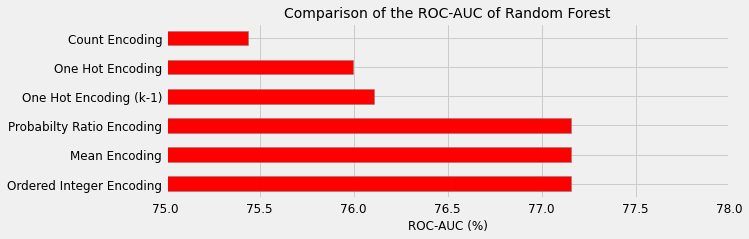

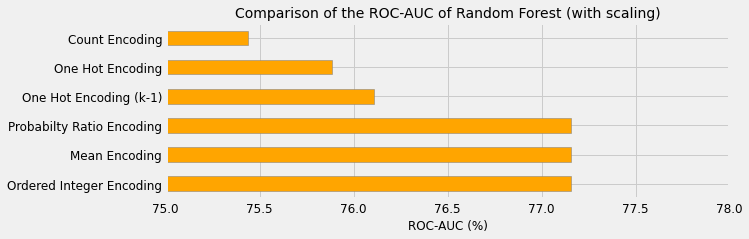

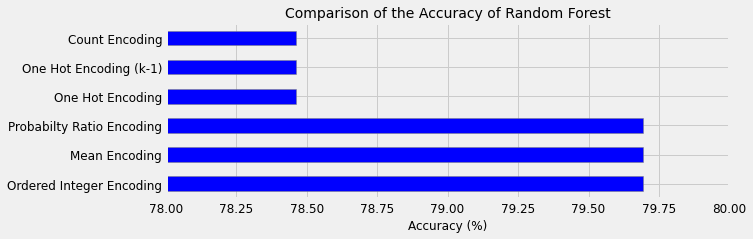

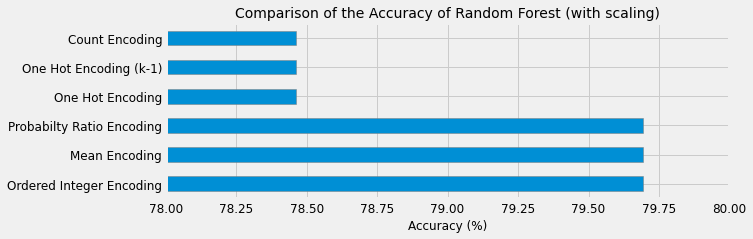

In [134]:
plt.style.use('fivethirtyeight');
model_rfc.sort_values('ROC_AUC', ascending = False).plot(x = 'Encoding', y = 'ROC_AUC', kind = 'barh', color = 'red', edgecolor = 'gray', figsize=(9,3));
plt.ylabel(''); plt.yticks(size = 12); plt.xlabel('ROC-AUC (%)',size = 12); plt.xticks(size = 12);
plt.title('Comparison of the ROC-AUC of Random Forest', size = 14); plt.xlim([75, 78]); plt.legend().set_visible(False);

plt.style.use('fivethirtyeight');
model_rfc_sc.sort_values('ROC_AUC', ascending = False).plot(x = 'Encoding', y = 'ROC_AUC', kind = 'barh', color = 'orange', edgecolor = 'gray', figsize=(9,3));
plt.ylabel(''); plt.yticks(size = 12); plt.xlabel('ROC-AUC (%)',size = 12); plt.xticks(size = 12);
plt.title('Comparison of the ROC-AUC of Random Forest (with scaling)', size = 14); plt.xlim([75, 78]); plt.legend().set_visible(False);

model_rfc.sort_values('Accuracy', ascending = False).plot(x = 'Encoding', y = 'Accuracy', kind = 'barh', color = 'blue', edgecolor = 'gray', figsize=(9,3));
plt.ylabel(''); plt.yticks(size = 12); plt.xlabel('Accuracy (%)',size = 12); plt.xticks(size = 12);
plt.title('Comparison of the Accuracy of Random Forest', size = 14); plt.xlim([78, 80]); plt.legend().set_visible(False);

model_rfc_sc.sort_values('Accuracy', ascending = False).plot(x = 'Encoding', y = 'Accuracy', kind = 'barh', edgecolor = 'gray', figsize=(9,3));
plt.ylabel(''); plt.yticks(size = 12); plt.xlabel('Accuracy (%)',size = 12); plt.xticks(size = 12);
plt.title('Comparison of the Accuracy of Random Forest (with scaling)', size = 14); plt.xlim([78, 80]); plt.legend().set_visible(False);

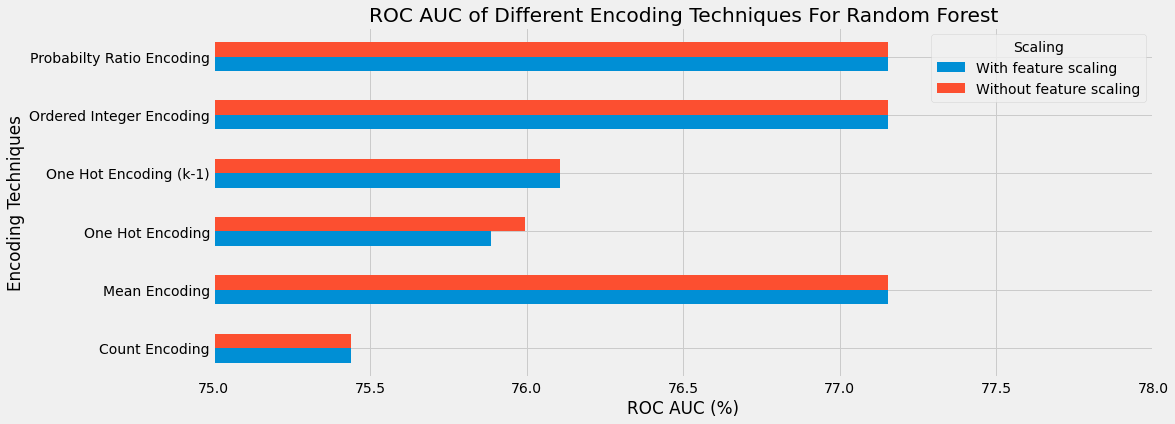

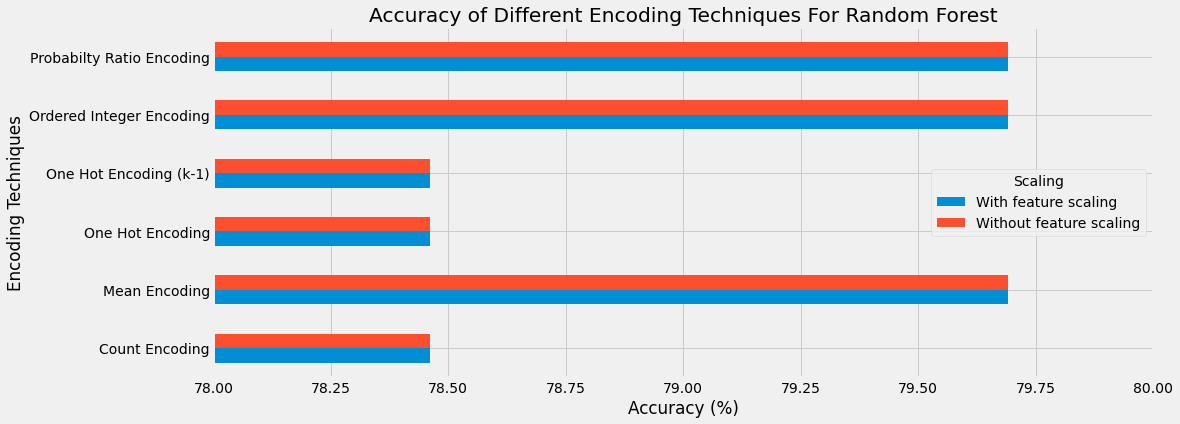

In [136]:
a1 = model_rfc.copy()
a1['Scaling']='Without feature scaling'
a1 = a1.drop('Accuracy',1)

a2 = model_rfc_sc.copy()
a2['Scaling']='With feature scaling'
a2 = a2.drop('Accuracy',1)

e1 = pd.concat([a1, a2], ignore_index=True)
e1.pivot(index='Encoding', columns='Scaling', values='ROC_AUC').plot(kind='barh', figsize=(15,6))
plt.ylabel('Encoding Techniques')
plt.xlabel('ROC AUC (%)')
plt.title('ROC AUC of Different Encoding Techniques For Random Forest')
plt.xlim([75, 78])
plt.show()

a1 = model_rfc.copy()
a1['Scaling']='Without feature scaling'
a1 = a1.drop('ROC_AUC',1)

a2 = model_rfc_sc.copy()
a2['Scaling']='With feature scaling'
a2 = a2.drop('ROC_AUC',1)

e1 = pd.concat([a1, a2], ignore_index=True)
e1.pivot(index='Encoding', columns='Scaling', values='Accuracy').plot(kind='barh', figsize=(15,6))
plt.legend.title=False
plt.ylabel('Encoding Techniques')
plt.xlabel('Accuracy (%)')
plt.title('Accuracy of Different Encoding Techniques For Random Forest')
plt.xlim([78, 80])
plt.show()

Ordered integer encoding, mean encoding, and probability ratio encoding had relatively higher ROC-AUC and accuracy scores (about 2%) than other encoding techniques. Order integer encoding, mean encoding, and probability ratio encoding techniques are all target-guided encoding techniques where a monotonic relationship is generated between categories and targets. 
The performance of one-hot encoding, one hot encoding (k-1 dummy) and count encoding was generally similar to each other. 
In addition, feature scaling did not affect the performance of the random forest classifier. This was expected since decision tree-based models are not sensitive to feature scaling.


# Neural Network

Neural networks are a computational model that shares some properties with the human brain in which many simple units are working in parallel with no centralized control unit. The weights between the units are the primary means of long-term information storage in neural networks. Updating the weights is the primary way the neural network learns new information.

In a neural network, the data is passed through the input layer to the hidden layers as a multi-variable linear combination, where the values are multiples by the corresponding weights and an activation function is applied to produce a weighted output. The weighted output is again transferred to the next layer as input and the same process is repeated before reaching the output layer, where the result of the output layer is compared to the desired output. A cost function is then calculated by determining the difference between the result from the output layer and the desired output. The weights are then updated using the calculated errors in the next iteration and the whole process is repeated until a global minimal cost function is determined.


In [80]:
def build_clf(unit, activation='linear', optimizer='SGD'):
    # creating the layers of the NN
    ann = tf.keras.models.Sequential()
    ann.add(tf.keras.layers.Dense(units=unit, activation=activation))
    ann.add(tf.keras.layers.Dense(units=unit, activation=activation))
    ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
    ann.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    return ann

def run_cv_ann(df_train, df_test, y_train, y_test):
    # Keras Classifier
    model = KerasClassifier(build_fn=build_clf)

    # hyperparameter space
    param_grid = dict(batch_size = [1, 3, 5, 10, 25], 
                      nb_epoch = [50, 100, 150, 150, 200],
                      unit = [10, 25, 50, 100, 150, 200], 
                      activation = ['relu', 'tanh', 'linear'],
                      )

    # K-Fold Cross-Validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=4)

    # search
    clf =  GridSearchCV(
    model,
    param_grid,
    scoring='roc_auc',
    cv=skf, # stratified k-fold
    refit=True, # refits best model to entire dataset
    n_jobs = -1,
    )

    clf.fit(df_train, y_train)

    # best hyperparameters
    print('Best model parameters: \t{}\n'.format(clf.best_params_))

    # get the predictions
    train_preds = clf.predict(df_train)
    test_preds = clf.predict(df_test)

    # calculate scores
    train_roc_auc = roc_auc_score(y_train, train_preds)
    train_accuarcy = accuracy_score(y_train, train_preds)

    test_roc_auc = roc_auc_score(y_test, test_preds)    
    test_accuarcy = accuracy_score(y_test, test_preds)

    print('Trainig Set\t-\tROC-AUC:\t{:.2f} %'.format(train_roc_auc*100))
    print('Trainig Set\t-\tAccuracy:\t{:.2f} %'.format(train_accuarcy*100))
    print('Testing Set\t-\tROC-AUC:\t{:.2f} %'.format(test_roc_auc*100))
    print('Testing Set\t-\tAccuracy:\t{:.2f} %'.format(test_accuarcy*100))

    return [test_roc_auc, test_accuarcy]

In [81]:
test_score = run_cv_ann(X_train_OHE, X_test_OHE, y_train, y_test)
model_ann = append_scores(model_ann,'One Hot Encoding', test_score)

325/325 [==============================] - 1s 792us/step - loss: 1.4596 - accuracy: 0.6574
Best model parameters: 	{'activation': 'linear', 'batch_size': 3, 'nb_epoch': 150, 'unit': 200}

Trainig Set	-	ROC-AUC:	50.61 %
Trainig Set	-	Accuracy:	63.38 %
Testing Set	-	ROC-AUC:	50.75 %
Testing Set	-	Accuracy:	59.38 %


In [82]:
test_score = run_cv_ann(X_train_OHE_kminus, X_test_OHE_kminus, y_train, y_test)
model_ann = append_scores(model_ann, 'One Hot Encoding (k-1)', test_score)

195/195 [==============================] - 0s 836us/step - loss: 1.5944 - accuracy: 0.6379
Best model parameters: 	{'activation': 'linear', 'batch_size': 5, 'nb_epoch': 50, 'unit': 200}

Trainig Set	-	ROC-AUC:	62.51 %
Trainig Set	-	Accuracy:	69.03 %
Testing Set	-	ROC-AUC:	56.18 %
Testing Set	-	Accuracy:	60.92 %


In [83]:
test_score = run_cv_ann(X_train_count, X_test_count, y_train, y_test)
model_ann = append_scores(model_ann, 'Count Encoding', test_score)

98/98 [==============================] - 0s 782us/step - loss: 0.5371 - accuracy: 0.7323
Best model parameters: 	{'activation': 'tanh', 'batch_size': 10, 'nb_epoch': 200, 'unit': 200}

Trainig Set	-	ROC-AUC:	76.04 %
Trainig Set	-	Accuracy:	77.95 %
Testing Set	-	ROC-AUC:	73.12 %
Testing Set	-	Accuracy:	75.08 %


In [84]:
test_score = run_cv_ann(X_train_ordered, X_test_ordered, y_train, y_test)
model_ann = append_scores(model_ann, 'Ordered Integer Encoding', test_score)

325/325 [==============================] - 0s 669us/step - loss: 1.4812 - accuracy: 0.6626
Best model parameters: 	{'activation': 'linear', 'batch_size': 3, 'nb_epoch': 150, 'unit': 200}

Trainig Set	-	ROC-AUC:	63.84 %
Trainig Set	-	Accuracy:	70.77 %
Testing Set	-	ROC-AUC:	58.20 %
Testing Set	-	Accuracy:	63.69 %


In [85]:
test_score = run_cv_ann(X_train_mean, X_test_mean, y_train, y_test)
model_ann = append_scores(model_ann, 'Mean Encoding', test_score)

98/98 [==============================] - 0s 905us/step - loss: 0.6153 - accuracy: 0.6769
Best model parameters: 	{'activation': 'tanh', 'batch_size': 10, 'nb_epoch': 150, 'unit': 200}

Trainig Set	-	ROC-AUC:	54.63 %
Trainig Set	-	Accuracy:	65.64 %
Testing Set	-	ROC-AUC:	53.80 %
Testing Set	-	Accuracy:	61.54 %


In [86]:
test_score = run_cv_ann(X_train_ratio, X_test_ratio, y_train, y_test)
model_ann = append_scores(model_ann, 'Probabilty Ratio Encoding', test_score)

195/195 [==============================] - 0s 718us/step - loss: 2.5693 - accuracy: 0.6513
Best model parameters: 	{'activation': 'linear', 'batch_size': 5, 'nb_epoch': 50, 'unit': 150}

Trainig Set	-	ROC-AUC:	63.85 %
Trainig Set	-	Accuracy:	71.79 %
Testing Set	-	ROC-AUC:	59.47 %
Testing Set	-	Accuracy:	65.85 %


In [87]:
test_score = run_cv_ann(X_train_OHE_sc, X_test_OHE_sc, y_train, y_test)
model_ann_sc = append_scores(model_ann_sc,'One Hot Encoding', test_score)

975/975 [==============================] - 1s 599us/step - loss: 0.4869 - accuracy: 0.77330s - loss: 0.4889 - accuracy: 0.77
Best model parameters: 	{'activation': 'relu', 'batch_size': 1, 'nb_epoch': 50, 'unit': 150}

Trainig Set	-	ROC-AUC:	78.31 %
Trainig Set	-	Accuracy:	81.23 %
Testing Set	-	ROC-AUC:	75.36 %
Testing Set	-	Accuracy:	77.85 %


In [88]:
test_score = run_cv_ann(X_train_OHE_kminus_sc, X_test_OHE_kminus_sc, y_train, y_test)
model_ann_sc = append_scores(model_ann_sc, 'One Hot Encoding (k-1)', test_score)

975/975 [==============================] - 1s 560us/step - loss: 0.4927 - accuracy: 0.7713
Best model parameters: 	{'activation': 'relu', 'batch_size': 1, 'nb_epoch': 200, 'unit': 100}

Trainig Set	-	ROC-AUC:	78.80 %
Trainig Set	-	Accuracy:	80.21 %
Testing Set	-	ROC-AUC:	74.68 %
Testing Set	-	Accuracy:	76.00 %


In [89]:
test_score = run_cv_ann(X_train_count_sc, X_test_count_sc, y_train, y_test)
model_ann_sc = append_scores(model_ann_sc, 'Count Encoding', test_score)

975/975 [==============================] - 1s 632us/step - loss: 0.5046 - accuracy: 0.76410s - loss: 0.5612 - ac
Best model parameters: 	{'activation': 'relu', 'batch_size': 1, 'nb_epoch': 200, 'unit': 200}

Trainig Set	-	ROC-AUC:	78.73 %
Trainig Set	-	Accuracy:	81.33 %
Testing Set	-	ROC-AUC:	74.43 %
Testing Set	-	Accuracy:	76.62 %


In [90]:
test_score = run_cv_ann(X_train_ordered_sc, X_test_ordered_sc, y_train, y_test)
model_ann_sc = append_scores(model_ann_sc, 'Ordered Integer Encoding', test_score)

975/975 [==============================] - 1s 599us/step - loss: 0.5007 - accuracy: 0.7610
Best model parameters: 	{'activation': 'relu', 'batch_size': 1, 'nb_epoch': 50, 'unit': 150}

Trainig Set	-	ROC-AUC:	80.13 %
Trainig Set	-	Accuracy:	81.95 %
Testing Set	-	ROC-AUC:	76.66 %
Testing Set	-	Accuracy:	78.46 %


In [91]:
test_score = run_cv_ann(X_train_mean_sc, X_test_mean_sc, y_train, y_test)
model_ann_sc = append_scores(model_ann_sc, 'Mean Encoding', test_score)

975/975 [==============================] - 1s 703us/step - loss: 0.4858 - accuracy: 0.7836
Best model parameters: 	{'activation': 'relu', 'batch_size': 1, 'nb_epoch': 150, 'unit': 200}

Trainig Set	-	ROC-AUC:	77.98 %
Trainig Set	-	Accuracy:	80.10 %
Testing Set	-	ROC-AUC:	75.62 %
Testing Set	-	Accuracy:	77.23 %


In [92]:
test_score = run_cv_ann(X_train_ratio_sc, X_test_ratio_sc, y_train, y_test)
model_ann_sc = append_scores(model_ann_sc, 'Probabilty Ratio Encoding', test_score)

975/975 [==============================] - 1s 576us/step - loss: 0.4975 - accuracy: 0.7723
Best model parameters: 	{'activation': 'relu', 'batch_size': 1, 'nb_epoch': 100, 'unit': 200}

Trainig Set	-	ROC-AUC:	78.09 %
Trainig Set	-	Accuracy:	80.82 %
Testing Set	-	ROC-AUC:	73.83 %
Testing Set	-	Accuracy:	76.31 %


## Results

In [93]:
model_ann

,Encoding,ROC_AUC,Accuracy
0,One Hot Encoding,50.746269,59.384615
1,One Hot Encoding (k-1),56.175275,60.923077
2,Count Encoding,73.116746,75.076923
3,Ordered Integer Encoding,58.197234,63.692308
4,Mean Encoding,53.803626,61.538462
5,Probabilty Ratio Encoding,59.472923,65.846154


In [94]:
model_ann_sc

,Encoding,ROC_AUC,Accuracy
0,One Hot Encoding,75.361413,77.846154
1,One Hot Encoding (k-1),74.681566,76.000000
2,Count Encoding,74.425647,76.615385
3,Ordered Integer Encoding,76.664453,78.461538
4,Mean Encoding,75.617332,77.230769
5,Probabilty Ratio Encoding,73.829804,76.307692


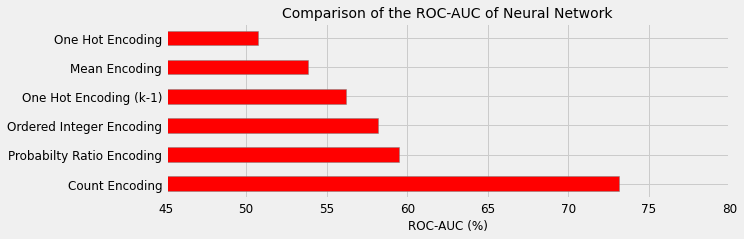

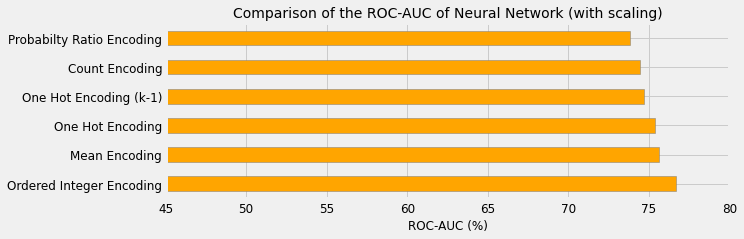

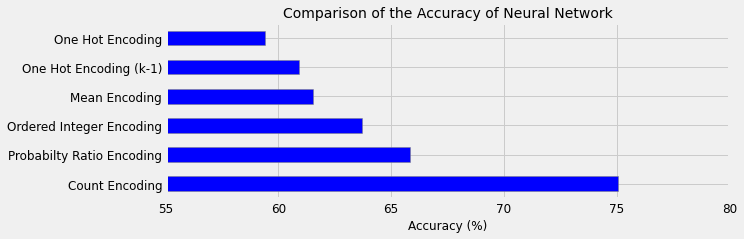

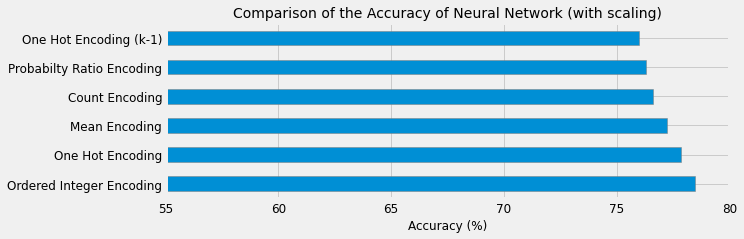

In [138]:
plt.style.use('fivethirtyeight');
model_ann.sort_values('ROC_AUC', ascending = False).plot(x = 'Encoding', y = 'ROC_AUC', kind = 'barh', color = 'red', edgecolor = 'gray', figsize=(9,3));
plt.ylabel(''); plt.yticks(size = 12); plt.xlabel('ROC-AUC (%)',size = 12); plt.xticks(size = 12);
plt.title('Comparison of the ROC-AUC of Neural Network', size = 14); plt.xlim([45, 80]); plt.legend().set_visible(False);

plt.style.use('fivethirtyeight');
model_ann_sc.sort_values('ROC_AUC', ascending = False).plot(x = 'Encoding', y = 'ROC_AUC', kind = 'barh', color = 'orange', edgecolor = 'gray', figsize=(9,3));
plt.ylabel(''); plt.yticks(size = 12); plt.xlabel('ROC-AUC (%)',size = 12); plt.xticks(size = 12);
plt.title('Comparison of the ROC-AUC of Neural Network (with scaling)', size = 14); plt.xlim([45, 80]); plt.legend().set_visible(False);

model_ann.sort_values('Accuracy', ascending = False).plot(x = 'Encoding', y = 'Accuracy', kind = 'barh', color = 'blue', edgecolor = 'gray', figsize=(9,3));
plt.ylabel(''); plt.yticks(size = 12); plt.xlabel('Accuracy (%)',size = 12); plt.xticks(size = 12);
plt.title('Comparison of the Accuracy of Neural Network', size = 14); plt.xlim([55, 80]); plt.legend().set_visible(False);

model_ann_sc.sort_values('Accuracy', ascending = False).plot(x = 'Encoding', y = 'Accuracy', kind = 'barh', edgecolor = 'gray', figsize=(9,3));
plt.ylabel(''); plt.yticks(size = 12); plt.xlabel('Accuracy (%)',size = 12); plt.xticks(size = 12);
plt.title('Comparison of the Accuracy of Neural Network (with scaling)', size = 14); plt.xlim([55, 80]); plt.legend().set_visible(False);

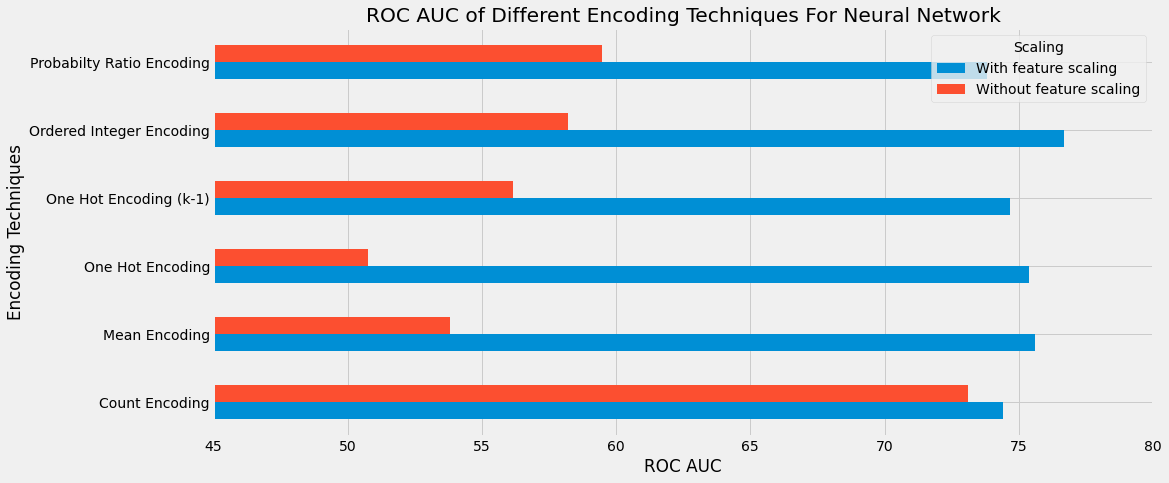

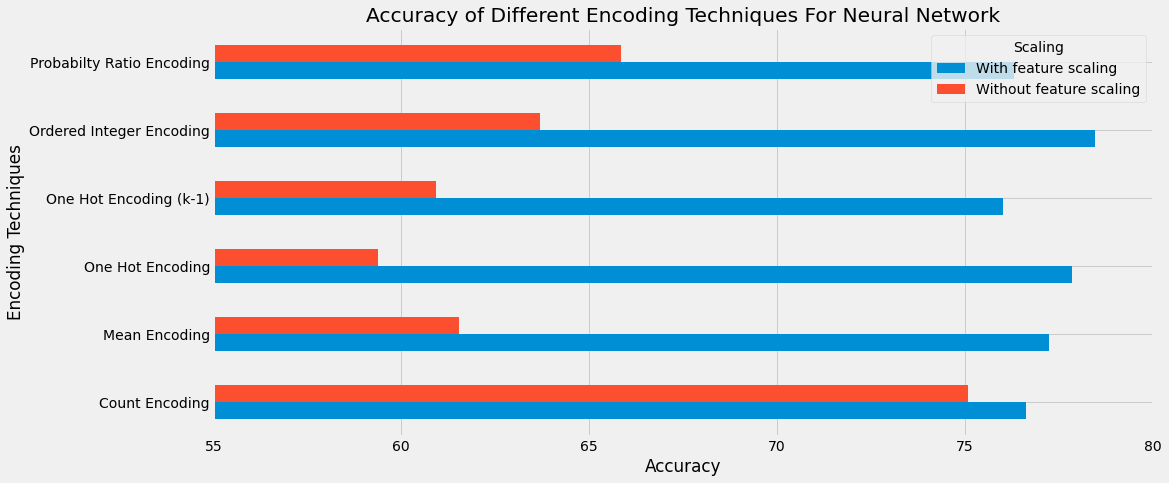

In [117]:
a1 = model_ann.copy()
a1['Scaling']='Without feature scaling'
a1 = a1.drop('Accuracy',1)

a2 = model_ann_sc.copy()
a2['Scaling']='With feature scaling'
a2 = a2.drop('Accuracy',1)

e1 = pd.concat([a1, a2], ignore_index=True)
e1.pivot(index='Encoding', columns='Scaling', values='ROC_AUC').plot(kind='barh', figsize=(15,7))
plt.ylabel('Encoding Techniques')
plt.xlabel('ROC AUC')
plt.title('ROC AUC of Different Encoding Techniques For Neural Network')
plt.xlim([45, 80])
plt.show()

a1 = model_ann.copy()
a1['Scaling']='Without feature scaling'
a1 = a1.drop('ROC_AUC',1)

a2 = model_ann_sc.copy()
a2['Scaling']='With feature scaling'
a2 = a2.drop('ROC_AUC',1)

e1 = pd.concat([a1, a2], ignore_index=True)
e1.pivot(index='Encoding', columns='Scaling', values='Accuracy').plot(kind='barh', figsize=(15,7))
plt.ylabel('Encoding Techniques')
plt.xlabel('Accuracy')
plt.title('Accuracy of Different Encoding Techniques For Neural Network')
plt.xlim([55, 80])
plt.show()

Feature scaling significantly improved the performance of all encoding techniques. This was expected since the neural network used gradient descent to find the global minimum cost function. 
Without feature scaling, one hot encoding had the lowest and count encoding had the highest ROC-AUC and accuracy scores. 
With feature scaling, ordered integer encoding had relatively higher ROC-AUC and accuracy scores compared to other encoding methods. 
The ROC-AUC and accuracy of one-hot encoding, ordered integer encoding, and mean encoding were about the same and they were slightly higher than other encoding techniques.


# Naive Bayes

Naive Bayes is a probabilistic classifier that assumes independence between the features of the data. It is popular for text classification applications, such as catching spam. One advantage of this model is that because it assumes feature independence, it can train a model with a small number of samples. (A downside is that it can’t capture the interactions between features.) This simple model can also work with data that has many features. As such, it serves as a good baseline model.

In [97]:
def run_cv_nbayes(df_train, df_test, y_train, y_test):
    # Navie Bayes Classifier
    gaussbn = GaussianNB()

    # hyperparameter space
    param_grid = {'var_smoothing': np.logspace(0,-9, num=30)}
    
    # K-Fold Cross-Validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=4)

    # search
    clf =  GridSearchCV(
    gaussbn,
    param_grid,
    scoring='roc_auc',
    cv=skf, # stratified k-fold
    refit=True, # refits best model to entire dataset
    n_jobs = -1,
    )

    clf.fit(df_train, y_train)

    # best hyperparameters
    print('Best model parameters: \t{}\n'.format(clf.best_params_))

    # get the predictions
    train_preds = clf.predict(df_train)
    test_preds = clf.predict(df_test)

    # calculate scores
    train_roc_auc = roc_auc_score(y_train, train_preds)
    train_accuarcy = accuracy_score(y_train, train_preds)

    test_roc_auc = roc_auc_score(y_test, test_preds)    
    test_accuarcy = accuracy_score(y_test, test_preds)

    print('Trainig Set\t-\tROC-AUC:\t{:.2f} %'.format(train_roc_auc*100))
    print('Trainig Set\t-\tAccuracy:\t{:.2f} %'.format(train_accuarcy*100))
    print('Testing Set\t-\tROC-AUC:\t{:.2f} %'.format(test_roc_auc*100))
    print('Testing Set\t-\tAccuracy:\t{:.2f} %'.format(test_accuarcy*100))

    return [test_roc_auc, test_accuarcy]

In [98]:
test_score = run_cv_nbayes(X_train_OHE, X_test_OHE, y_train, y_test)
model_nb = append_scores(model_nb,'One Hot Encoding', test_score)

Best model parameters: 	{'var_smoothing': 9.236708571873866e-05}

Trainig Set	-	ROC-AUC:	68.27 %
Trainig Set	-	Accuracy:	74.77 %
Testing Set	-	ROC-AUC:	64.92 %
Testing Set	-	Accuracy:	70.15 %


In [99]:
test_score = run_cv_nbayes(X_train_OHE_kminus, X_test_OHE_kminus, y_train, y_test)
model_nb = append_scores(model_nb, 'One Hot Encoding (k-1)', test_score)

Best model parameters: 	{'var_smoothing': 4.520353656360241e-05}

Trainig Set	-	ROC-AUC:	65.93 %
Trainig Set	-	Accuracy:	71.90 %
Testing Set	-	ROC-AUC:	62.83 %
Testing Set	-	Accuracy:	67.69 %


In [100]:
test_score = run_cv_nbayes(X_train_count, X_test_count, y_train, y_test)
model_nb = append_scores(model_nb, 'Count Encoding', test_score)

Best model parameters: 	{'var_smoothing': 1.082636733874054e-05}

Trainig Set	-	ROC-AUC:	77.70 %
Trainig Set	-	Accuracy:	77.95 %
Testing Set	-	ROC-AUC:	76.47 %
Testing Set	-	Accuracy:	77.85 %


In [101]:
test_score = run_cv_nbayes(X_train_ordered, X_test_ordered, y_train, y_test)
model_nb = append_scores(model_nb, 'Ordered Integer Encoding', test_score)

Best model parameters: 	{'var_smoothing': 1.743328822199987e-08}

Trainig Set	-	ROC-AUC:	74.85 %
Trainig Set	-	Accuracy:	77.23 %
Testing Set	-	ROC-AUC:	72.78 %
Testing Set	-	Accuracy:	75.08 %


In [102]:
test_score = run_cv_nbayes(X_train_mean, X_test_mean, y_train, y_test)
model_nb = append_scores(model_nb, 'Mean Encoding', test_score)

Best model parameters: 	{'var_smoothing': 1.2689610031679208e-06}

Trainig Set	-	ROC-AUC:	75.05 %
Trainig Set	-	Accuracy:	77.85 %
Testing Set	-	ROC-AUC:	71.93 %
Testing Set	-	Accuracy:	74.46 %


In [103]:
test_score = run_cv_nbayes(X_train_ratio, X_test_ratio, y_train, y_test)
model_nb = append_scores(model_nb, 'Probabilty Ratio Encoding', test_score)

Best model parameters: 	{'var_smoothing': 0.00038566204211634724}

Trainig Set	-	ROC-AUC:	67.87 %
Trainig Set	-	Accuracy:	74.77 %
Testing Set	-	ROC-AUC:	63.54 %
Testing Set	-	Accuracy:	68.92 %


In [104]:
test_score = run_cv_nbayes(X_train_OHE_sc, X_test_OHE_sc, y_train, y_test)
model_nb_sc = append_scores(model_nb_sc,'One Hot Encoding', test_score)

Best model parameters: 	{'var_smoothing': 1.0}

Trainig Set	-	ROC-AUC:	65.75 %
Trainig Set	-	Accuracy:	72.10 %
Testing Set	-	ROC-AUC:	62.60 %
Testing Set	-	Accuracy:	67.69 %


In [105]:
test_score = run_cv_nbayes(X_train_OHE_kminus_sc, X_test_OHE_kminus_sc, y_train, y_test)
model_nb_sc = append_scores(model_nb_sc, 'One Hot Encoding (k-1)', test_score)

Best model parameters: 	{'var_smoothing': 1.0}

Trainig Set	-	ROC-AUC:	64.16 %
Trainig Set	-	Accuracy:	70.46 %
Testing Set	-	ROC-AUC:	61.07 %
Testing Set	-	Accuracy:	66.15 %


In [106]:
test_score = run_cv_nbayes(X_train_count_sc, X_test_count_sc, y_train, y_test)
model_nb_sc = append_scores(model_nb_sc, 'Count Encoding', test_score)

Best model parameters: 	{'var_smoothing': 1.0}

Trainig Set	-	ROC-AUC:	67.77 %
Trainig Set	-	Accuracy:	73.64 %
Testing Set	-	ROC-AUC:	64.25 %
Testing Set	-	Accuracy:	69.23 %


In [107]:
test_score = run_cv_nbayes(X_train_ordered_sc, X_test_ordered_sc, y_train, y_test)
model_nb_sc = append_scores(model_nb_sc, 'Ordered Integer Encoding', test_score)

Best model parameters: 	{'var_smoothing': 1.0}

Trainig Set	-	ROC-AUC:	67.01 %
Trainig Set	-	Accuracy:	73.33 %
Testing Set	-	ROC-AUC:	63.76 %
Testing Set	-	Accuracy:	68.92 %


In [108]:
test_score = run_cv_nbayes(X_train_mean_sc, X_test_mean_sc, y_train, y_test)
model_nb_sc = append_scores(model_nb_sc, 'Mean Encoding', test_score)

Best model parameters: 	{'var_smoothing': 1.0}

Trainig Set	-	ROC-AUC:	67.05 %
Trainig Set	-	Accuracy:	73.23 %
Testing Set	-	ROC-AUC:	63.87 %
Testing Set	-	Accuracy:	68.92 %


In [109]:
test_score = run_cv_nbayes(X_train_ratio_sc, X_test_ratio_sc, y_train, y_test)
model_nb_sc = append_scores(model_nb_sc, 'Probabilty Ratio Encoding', test_score)

Best model parameters: 	{'var_smoothing': 1.0}

Trainig Set	-	ROC-AUC:	67.05 %
Trainig Set	-	Accuracy:	73.23 %
Testing Set	-	ROC-AUC:	63.87 %
Testing Set	-	Accuracy:	68.92 %


## Results

In [110]:
model_nb

,Encoding,ROC_AUC,Accuracy
0,One Hot Encoding,64.919512,70.153846
1,One Hot Encoding (k-1),62.825272,67.692308
2,Count Encoding,76.474955,77.846154
3,Ordered Integer Encoding,72.782683,75.076923
4,Mean Encoding,71.925061,74.461538
5,Probabilty Ratio Encoding,63.538329,68.923077


In [111]:
model_nb_sc

,Encoding,ROC_AUC,Accuracy
0,One Hot Encoding,62.602563,67.692308
1,One Hot Encoding (k-1),61.070954,66.153846
2,Count Encoding,64.245526,69.230769
3,Ordered Integer Encoding,63.761038,68.923077
4,Mean Encoding,63.872392,68.923077
5,Probabilty Ratio Encoding,63.872392,68.923077


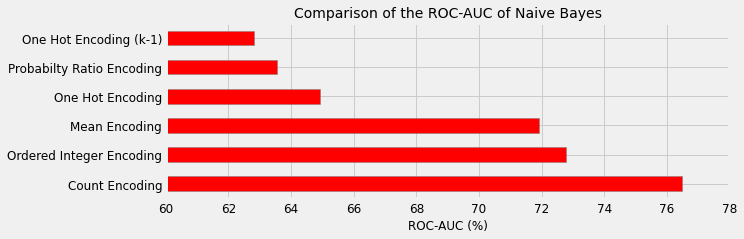

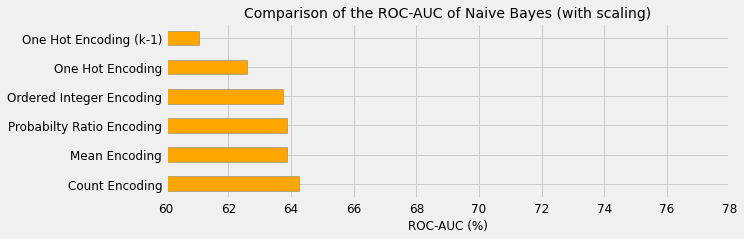

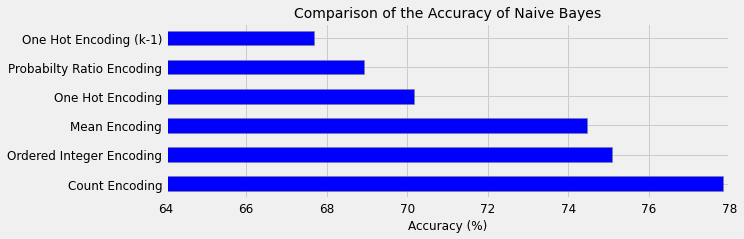

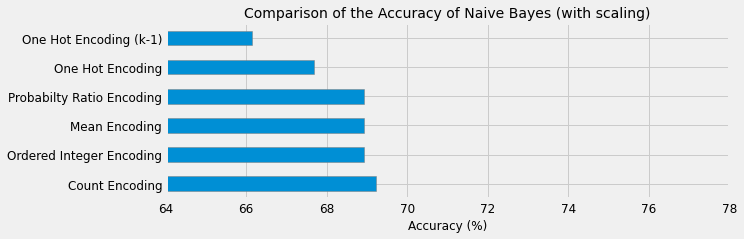

In [143]:
plt.style.use('fivethirtyeight');
model_nb.sort_values('ROC_AUC', ascending = False).plot(x = 'Encoding', y = 'ROC_AUC', kind = 'barh', color = 'red', edgecolor = 'gray', figsize=(9,3));
plt.ylabel(''); plt.yticks(size = 12); plt.xlabel('ROC-AUC (%)',size = 12); plt.xticks(size = 12);
plt.title('Comparison of the ROC-AUC of Naive Bayes', size = 14); plt.xlim([60, 78]); plt.legend().set_visible(False);

plt.style.use('fivethirtyeight');
model_nb_sc.sort_values('ROC_AUC', ascending = False).plot(x = 'Encoding', y = 'ROC_AUC', kind = 'barh', color = 'orange', edgecolor = 'gray', figsize=(9,3));
plt.ylabel(''); plt.yticks(size = 12); plt.xlabel('ROC-AUC (%)',size = 12); plt.xticks(size = 12);
plt.title('Comparison of the ROC-AUC of Naive Bayes (with scaling)', size = 14); plt.xlim([60, 78]); plt.legend().set_visible(False);

model_nb.sort_values('Accuracy', ascending = False).plot(x = 'Encoding', y = 'Accuracy', kind = 'barh', color = 'blue', edgecolor = 'gray', figsize=(9,3));
plt.ylabel(''); plt.yticks(size = 12); plt.xlabel('Accuracy (%)',size = 12); plt.xticks(size = 12);
plt.title('Comparison of the Accuracy of Naive Bayes', size = 14); plt.xlim([64, 78]); plt.legend().set_visible(False);

model_nb_sc.sort_values('Accuracy', ascending = False).plot(x = 'Encoding', y = 'Accuracy', kind = 'barh', edgecolor = 'gray', figsize=(9,3));
plt.ylabel(''); plt.yticks(size = 12); plt.xlabel('Accuracy (%)',size = 12); plt.xticks(size = 12);
plt.title('Comparison of the Accuracy of Naive Bayes (with scaling)', size = 14); plt.xlim([64, 78]); plt.legend().set_visible(False);

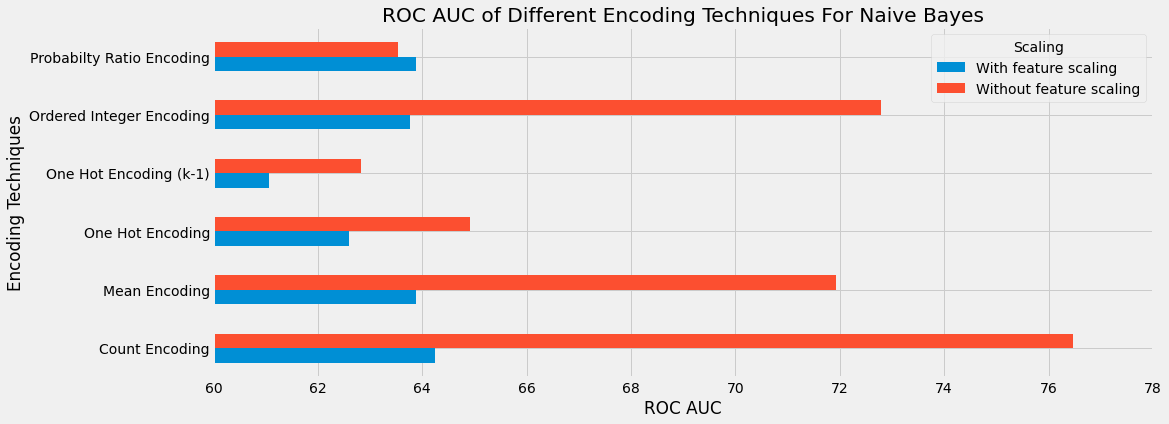

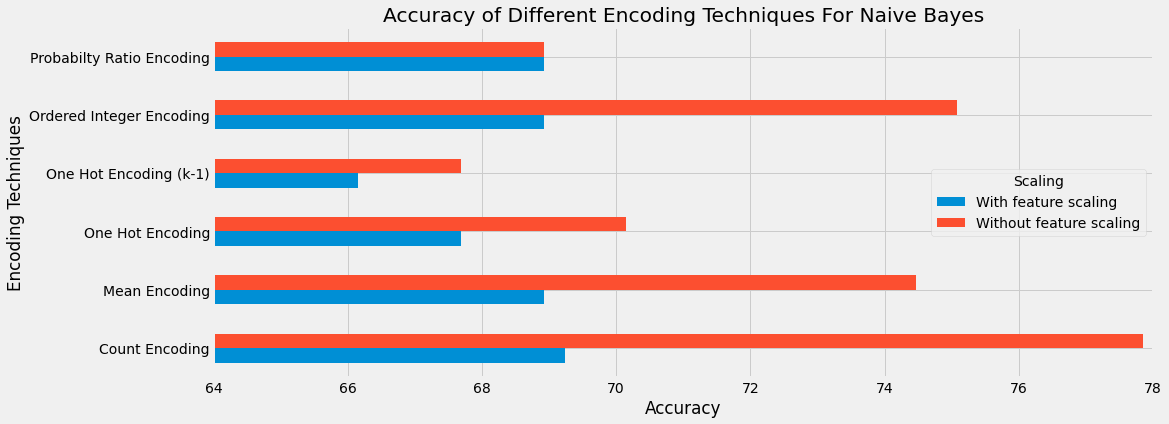

In [144]:
a1 = model_nb.copy()
a1['Scaling']='Without feature scaling'
a1 = a1.drop('Accuracy',1)

a2 = model_nb_sc.copy()
a2['Scaling']='With feature scaling'
a2 = a2.drop('Accuracy',1)

e1 = pd.concat([a1, a2], ignore_index=True)
e1.pivot(index='Encoding', columns='Scaling', values='ROC_AUC').plot(kind='barh', figsize=(15,6))
plt.ylabel('Encoding Techniques')
plt.xlabel('ROC AUC')
plt.title('ROC AUC of Different Encoding Techniques For Naive Bayes')
plt.xlim([60, 78])
plt.show()

a1 = model_nb.copy()
a1['Scaling']='Without feature scaling'
a1 = a1.drop('ROC_AUC',1)

a2 = model_nb_sc.copy()
a2['Scaling']='With feature scaling'
a2 = a2.drop('ROC_AUC',1)

e1 = pd.concat([a1, a2], ignore_index=True)
e1.pivot(index='Encoding', columns='Scaling', values='Accuracy').plot(kind='barh', figsize=(15,6))
plt.ylabel('Encoding Techniques')
plt.xlabel('Accuracy')
plt.title('Accuracy of Different Encoding Techniques For Naive Bayes')
plt.xlim([64, 78])
plt.show()

Count encoding had the highest ROC-AUC and accuracy scores for both with and without feature scalings. However, with feature scaling the performance of count encoding was similar to mean encoding, probability encoding, and order integer encoding. One hot encoding (k-1) had the lowest scores for both with and without feature scaling. 
Even though the Naive Bayes classifier is not sensitive to feature scaling since it's a probabilistic model, feature scaling reduced the performance of categorical encoding techniques (except probability ratio encoding technique where it remained relatively the same). It's worth investigating the effects of feature scaling on Naive Bayes further.


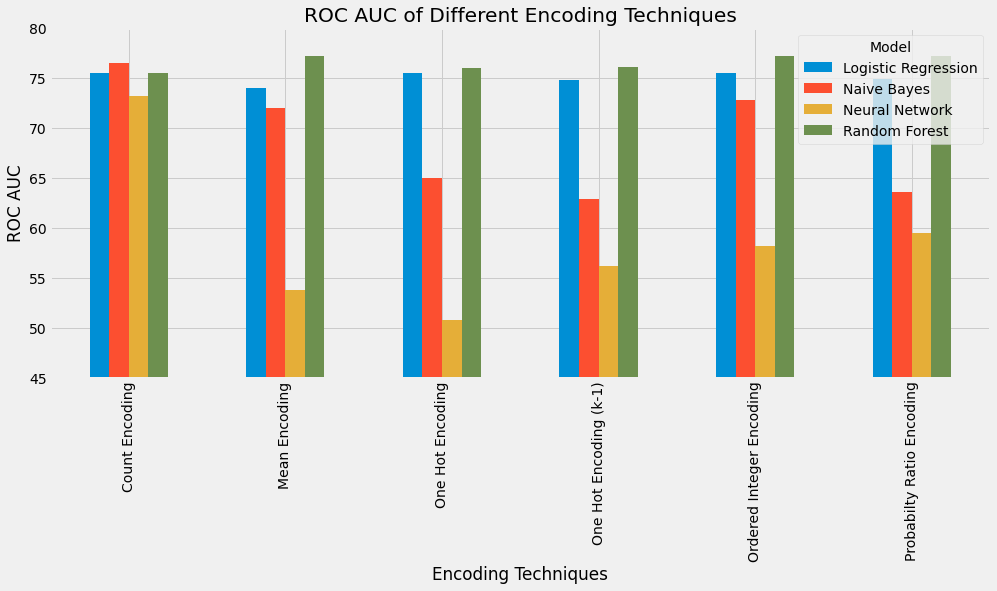

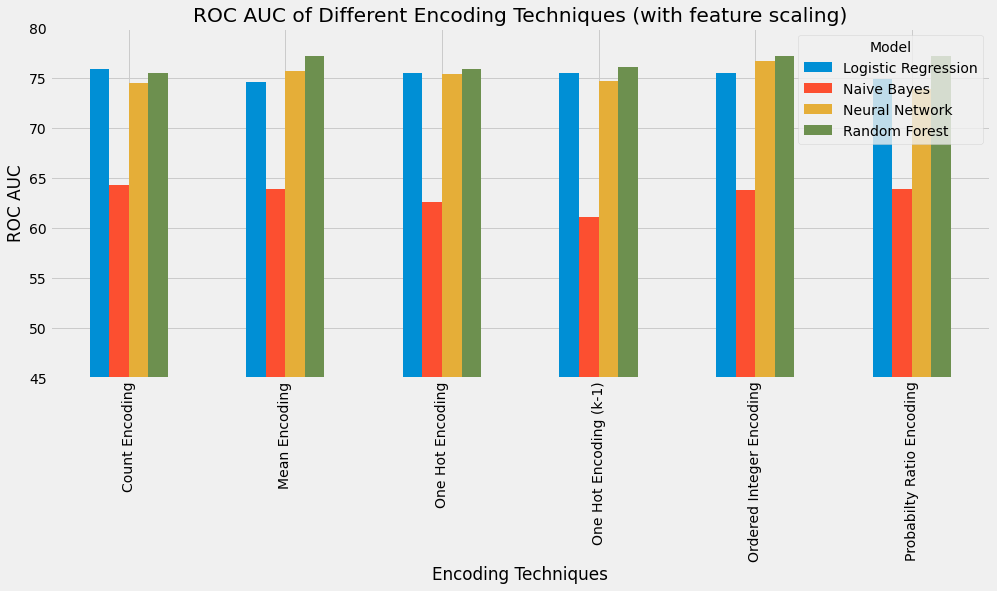

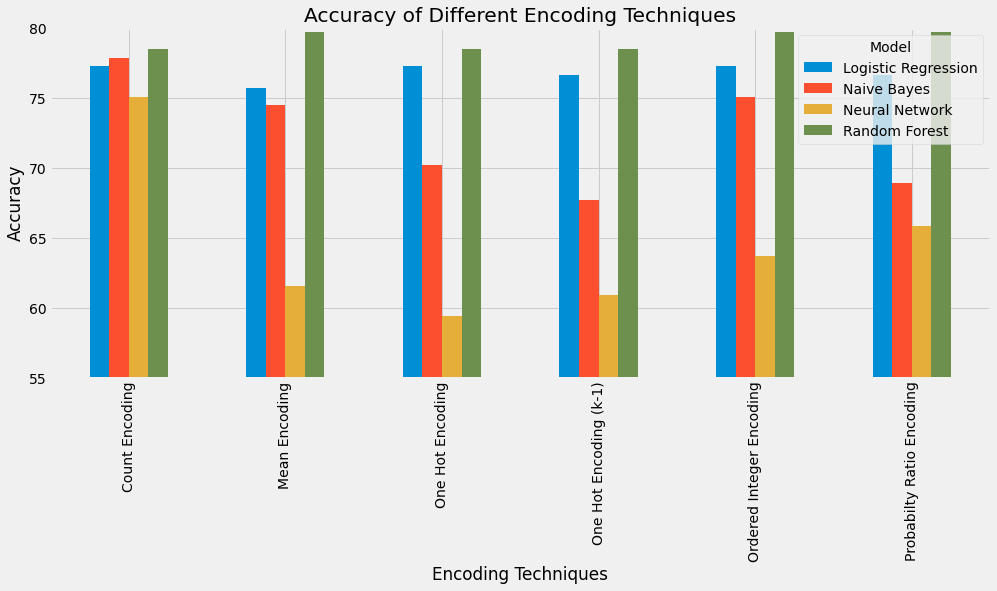

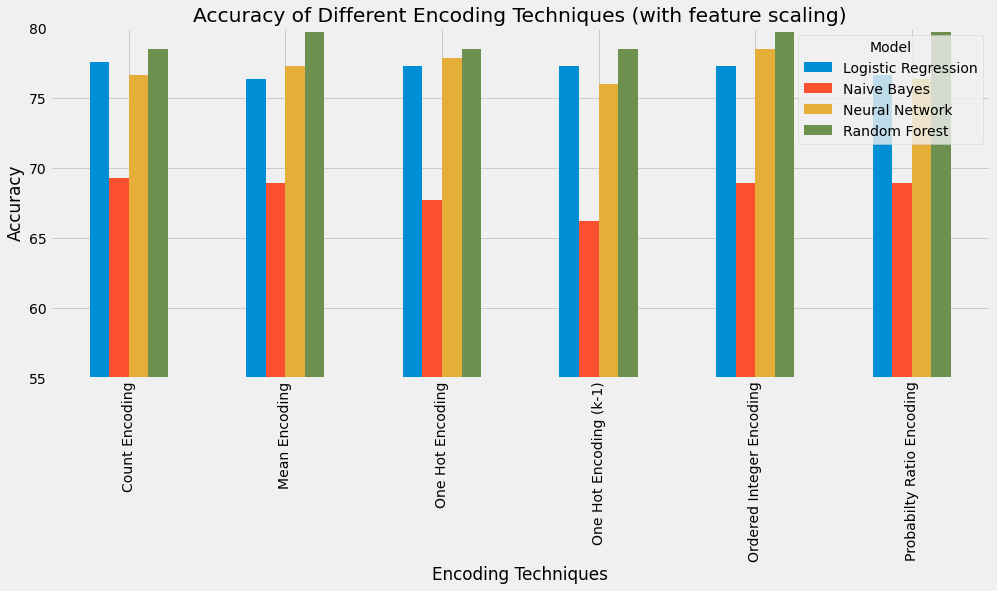

In [114]:
aa = model_logit.copy()
aa['Model']='Logistic Regression'
aa = aa.drop('Accuracy',1)

bb = model_rfc.copy()
bb['Model']='Random Forest'
bb = bb.drop('Accuracy',1)

cc = model_ann.copy()
cc['Model']='Neural Network'
cc = cc.drop('Accuracy',1)

dd = model_nb.copy()
dd['Model']='Naive Bayes'
dd = dd.drop('Accuracy',1)

ee = pd.concat([aa, bb, cc, dd], ignore_index=True)
ee.pivot(index='Encoding', columns='Model', values='ROC_AUC').plot(kind='bar', figsize=(15,6))
plt.xlabel('Encoding Techniques')
plt.ylabel('ROC AUC')
plt.title('ROC AUC of Different Encoding Techniques')
plt.ylim([45, 80])
plt.show()

aa = model_logit_sc.copy()
aa['Model']='Logistic Regression'
aa = aa.drop('Accuracy',1)

bb = model_rfc_sc.copy()
bb['Model']='Random Forest'
bb = bb.drop('Accuracy',1)

cc = model_ann_sc.copy()
cc['Model']='Neural Network'
cc = cc.drop('Accuracy',1)

dd = model_nb_sc.copy()
dd['Model']='Naive Bayes'
dd = dd.drop('Accuracy',1)

ee = pd.concat([aa, bb, cc, dd], ignore_index=True)
ee.pivot(index='Encoding', columns='Model', values='ROC_AUC').plot(kind='bar', figsize=(15,6))
plt.xlabel('Encoding Techniques')
plt.ylabel('ROC AUC')
plt.title('ROC AUC of Different Encoding Techniques (with feature scaling)')
plt.ylim([45, 80])
plt.show()

aa = model_logit.copy()
aa['Model']='Logistic Regression'
aa = aa.drop('ROC_AUC',1)

bb = model_rfc.copy()
bb['Model']='Random Forest'
bb = bb.drop('ROC_AUC',1)

cc = model_ann.copy()
cc['Model']='Neural Network'
cc = cc.drop('ROC_AUC',1)

dd = model_nb.copy()
dd['Model']='Naive Bayes'
dd = dd.drop('ROC_AUC',1)

ee = pd.concat([aa, bb, cc, dd], ignore_index=True)
ee.pivot(index='Encoding', columns='Model', values='Accuracy').plot(kind='bar', figsize=(15,6))
plt.xlabel('Encoding Techniques')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Encoding Techniques')
plt.ylim([55, 80])
plt.show()

aa = model_logit_sc.copy()
aa['Model']='Logistic Regression'
aa = aa.drop('ROC_AUC',1)

bb = model_rfc_sc.copy()
bb['Model']='Random Forest'
bb = bb.drop('ROC_AUC',1)

cc = model_ann_sc.copy()
cc['Model']='Neural Network'
cc = cc.drop('ROC_AUC',1)

dd = model_nb_sc.copy()
dd['Model']='Naive Bayes'
dd = dd.drop('ROC_AUC',1)

ee = pd.concat([aa, bb, cc, dd], ignore_index=True)
ee.pivot(index='Encoding', columns='Model', values='Accuracy').plot(kind='bar', figsize=(15,6))
plt.xlabel('Encoding Techniques')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Encoding Techniques (with feature scaling)')
plt.ylim([55, 80])
plt.show()

# Conclusions

Feature scaling either improved or did not affect the performance of logistic regression, random forest and neural network classifiers. Feature scaling reduced the performance of the Naive Bayes classifier and it might be worth investigating this effect further. 

For logistic regression, all encoding techniques performed similarly with count encoding having slightly higher scores. 
For random forest, ordered integer encoding, mean encoding, and probability ratio encoding performed marginally better compared to other encoding techniques. 
For neural networks, one-hot encoding, ordered integer encoding, and mean encoding performed slightly better compared to other encoding techniques. 
For the Naive Bayes classifier, count encoding without feature scaling performed better than other encoding techniques. 
One hot encoding, one hot encoding (k-1), and ordered integer encoding methods performed similarly to each other for logistic regression, random forest and neural network classifiers. 
One hot encoding, one hot encoding (k-1), and ordered integer encoding methods performed relatively better for logistic regression, random forest, and neural network classifiers. Thus, either one of these encoding techniques might be a safe choice. 

It is worth noting that the effect of these categorical encoding techniques has not been studied for datasets with a large number of categorical features and categorical features with high cardinality.

